In [1]:
#import os
#from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import requests
import json

from collections import Counter

In [2]:
response = requests.post('https://services.cloud.mongodb.com/api/client/v2.0/app/data-odirfmm/auth/providers/anon-user/login')
token = response.json().get('access_token')

In [3]:
DATA_API_URL = "https://us-east-1.aws.data.mongodb-api.com/app/data-odirfmm/endpoint/data/v1/action/find"

payload = json.dumps({
    "collection": "spectral_library",
    "database": "upwins_db",
    "dataSource": "Cluster0",
    "limit": 2000
})
headers = {
  'Content-Type': 'application/json',
  'Access-Control-Request-Headers': '*',
  'Authorization': f'Bearer {token}',
}

response = requests.request("POST", DATA_API_URL, headers=headers, data=payload, stream=True)

In [4]:
data_dict = json.loads(response.text)
df = pd.DataFrame(data_dict['documents'])

In [5]:
names = df['ASD UPWINS base_fname'].to_numpy()
wl = np.array(list(df['spectrum'][0].keys()), dtype=float)
spectra = np.array([list(spectrum.values()) for spectrum in df['spectrum']])

In [6]:
# remove spectra with large derivate, which are the spectra collected using sunlight
derivitive = np.mean(np.abs(spectra[:,1:]-spectra[:,:-1]), axis=1)
select_indices = np.where(derivitive<0.0025)[0]
# create variables for the library data 
names = names[select_indices]
spectra = spectra[select_indices,:]
#wl = np.asarray(lib.bands.centers)
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

#print(' ')
#print('...remove spectra collected using outdoor solar illumination...')
#print(' ')
#print(f'Number of spectra: {nSpec}')
#print(f'Number of bands: {nBands}')

In [7]:
# Extract the metadata as numpy arrays
genus = []
species = []
principle_part = []
health = []
growth_stage = []
DateTimeId = []
month = []
plant_type = []
name = []
name_full_category = []
name_genus_species = []
select_indices = []
for i in range(len(df)):
    
    try:

        row = df.loc[df['ASD UPWINS base_fname'] == names[i]]

        # if the spectrum has a corresponding row in the csv
        if (row['sub-category'].values[0] not in ['NA','backrounds']) & (row['category'].values[0] in ['vegetation','target_vegetation','soil','road']):
            select_indices.append(i)
            plant_type.append(row['sub-category'].values[0])
            genus.append(row['genus'].values[0])
            species.append(row['species'].values[0])
            principle_part.append(row['principal_part'].values[0])
            health.append(row['health'].values[0])
            growth_stage.append(row['growth_stage'].values[0])
            name_genus_species.append(row['genus'].values[0]+'_'+row['species'].values[0])
            DateTimeId.append(row['DateTimeUniqueIdentifier'].values[0])
            month.append(row['DateTimeUniqueIdentifier'].values[0][4:6])
            if row['genus'].values[0]=='NA':
                #not in our primary target vegetation library
                name.append(row['sub-category'].values[0])
                name_full_category.append(row['sub-category'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])
            else:
                name.append(row['genus'].values[0]+'_'+row['species'].values[0])
                name_full_category.append(row['genus'].values[0]+'_'+row['species'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])
    except:
        continue

#print(len(select_indices))

names = names[select_indices]
spectra = spectra[select_indices,:]
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

#print(f'Number of spectra: {nSpec}')
#print(f'Number of bands: {nBands}')
genus = np.asarray(genus)
species = np.asarray(species)
principle_part = np.asarray(principle_part)
health = np.asarray(health)
growth_stage = np.asarray(growth_stage)
DateTimeId = np.asarray(DateTimeId)
month = np.asarray(month)
name = np.asarray(name)
name_genus_species = np.asarray(name_genus_species)
name_full_category = np.asarray(name_full_category)
plant_type = np.asarray(plant_type)


In [8]:
nSpec = spectra.shape[0]
nBands = spectra.shape[1]
minWl = float(np.min(wl))
maxWl = float(np.max(wl))

#print(f'Min wavelength: {np.min(wl)}')
#print(f'Max wavelength: {np.max(wl)}')
#print(f'Number of Spectra: {nSpec}')
#print(f'Number of Bands: {nBands}')

## Totals

Min wavelength: `{python} minWl`\
Max wavelength: `{python} maxWl`\
Number of Spectra: `{python} nSpec`\
Number of Bands: `{python} nBands`

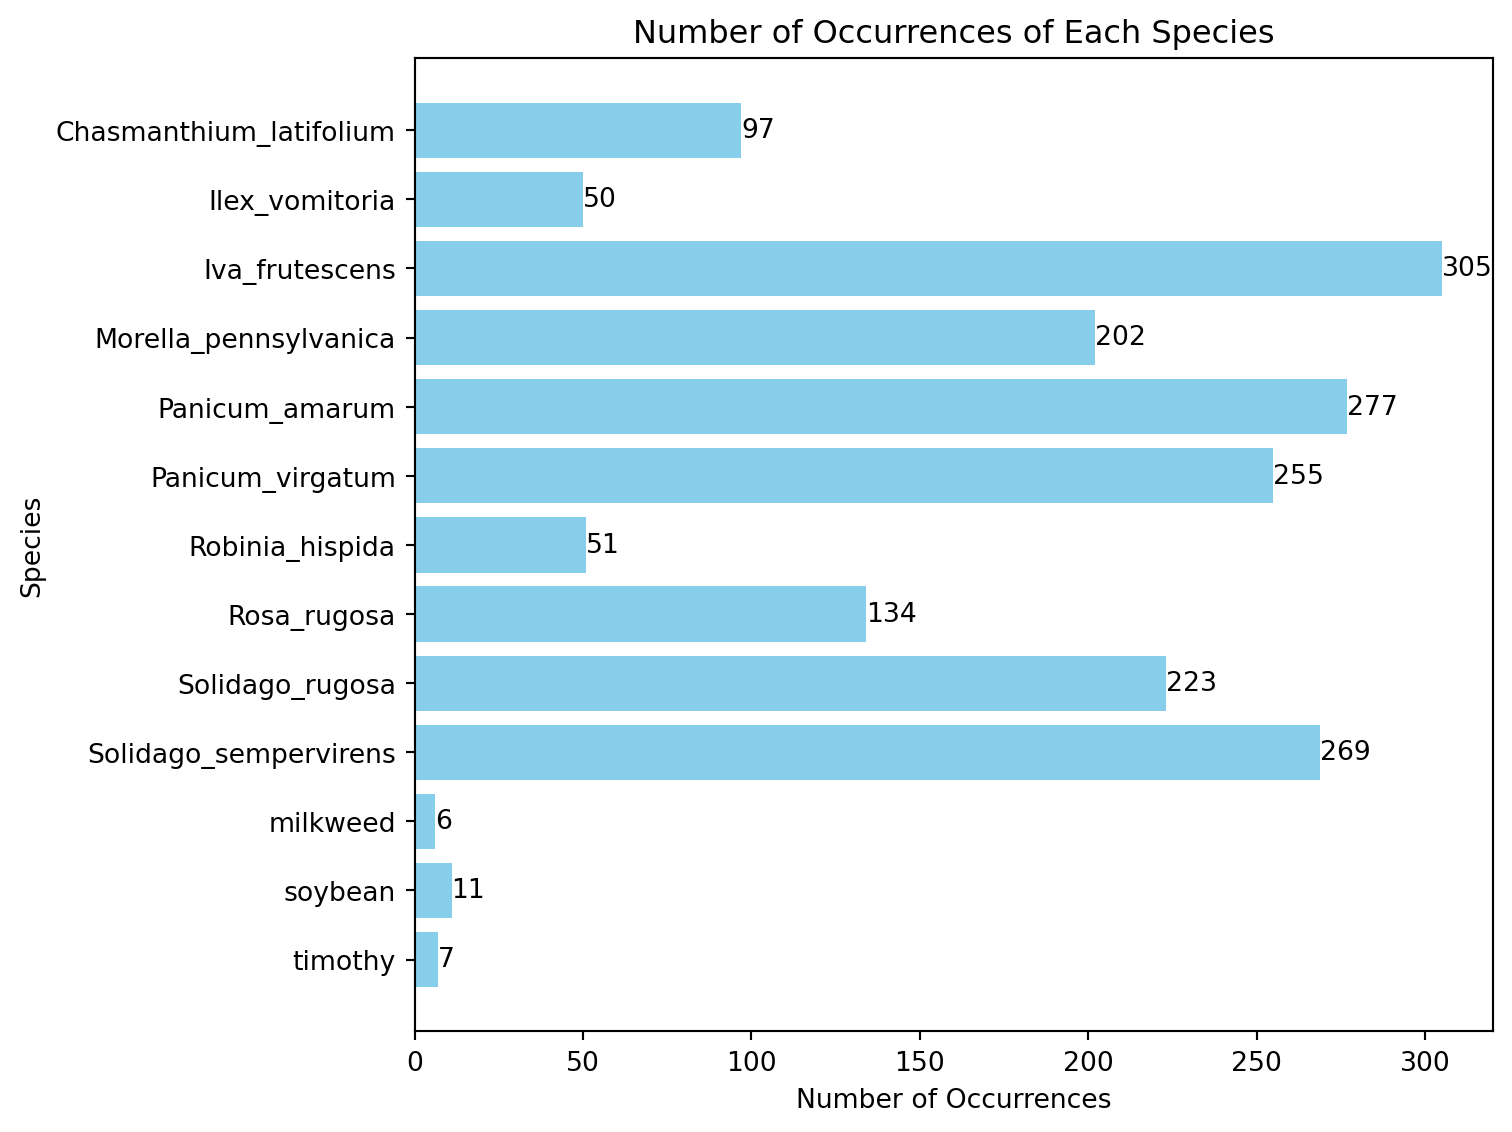

In [9]:
#| label: fig-label
#| fig-cap: Number of Occurrences of Each Species
#| column: page-inset-right

# Count the occurrences of each unique value
name_counts = Counter(name)

#print(name_counts.items())
#print(*name_counts.items())

# Extract the labels and values
labels, values = zip(*name_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, values, color='skyblue')
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species')
plt.tight_layout()
plt.show()

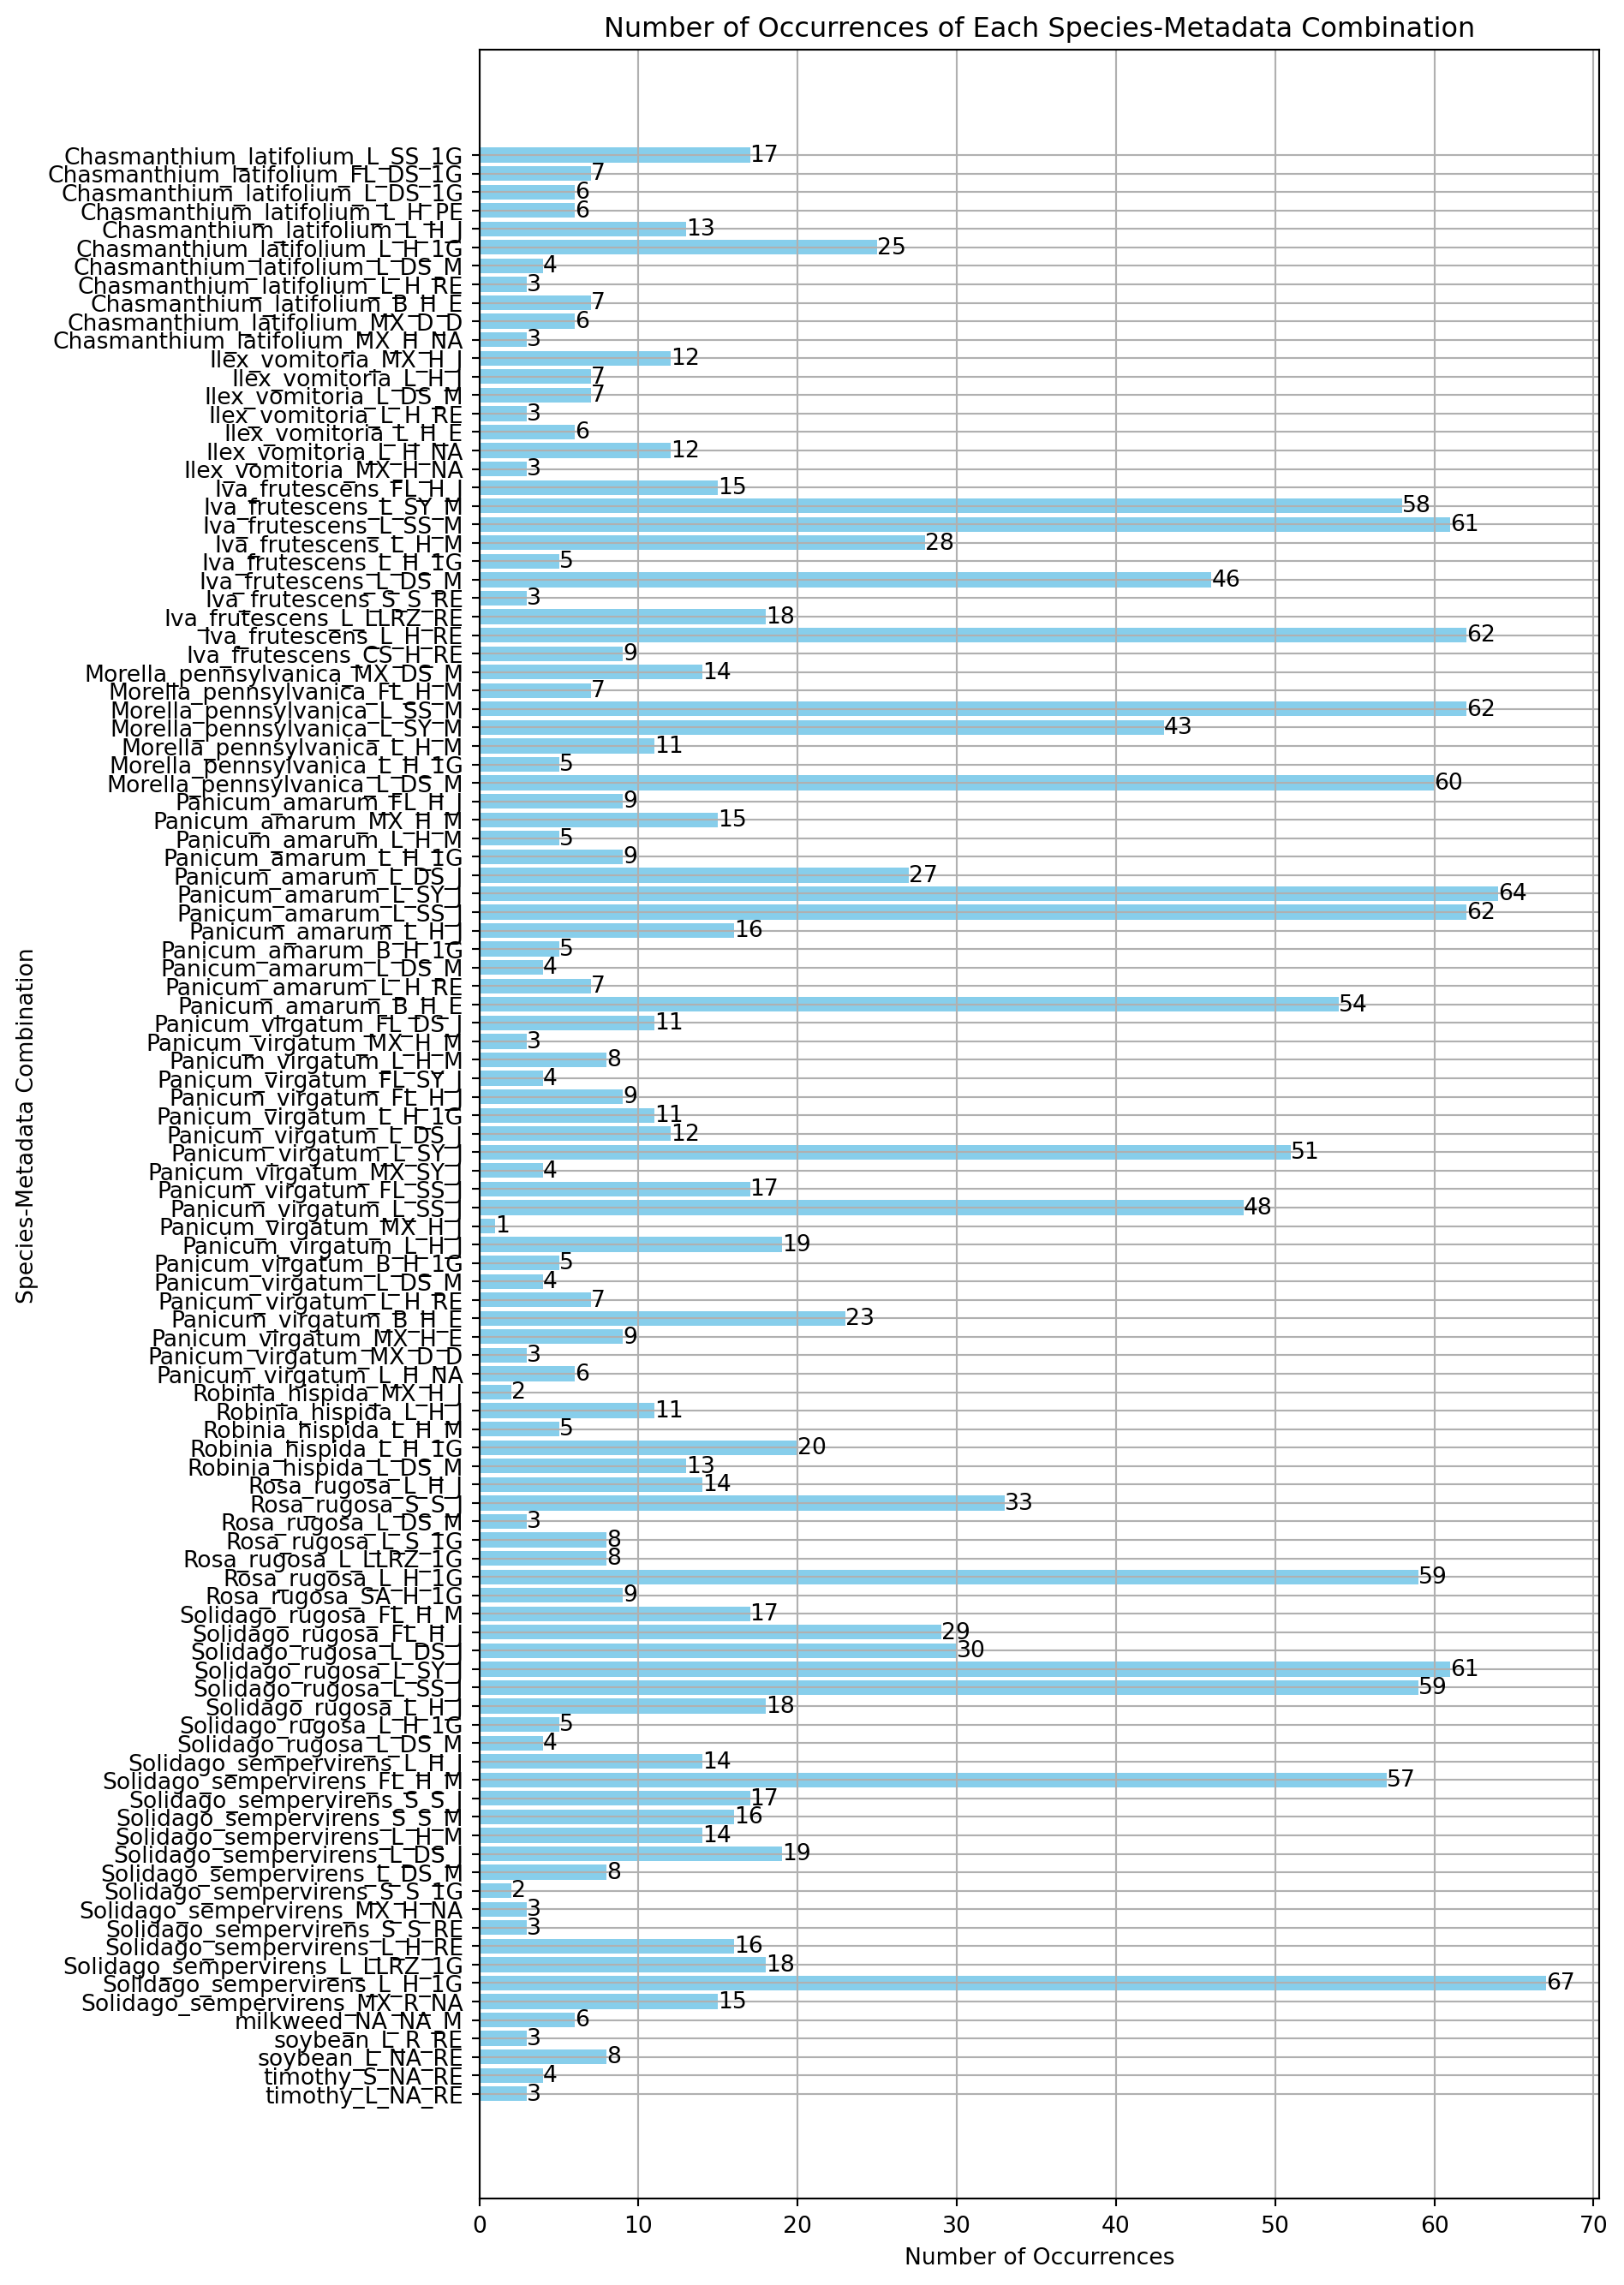

In [10]:
#| label: fig-label2
#| fig-cap: Number of Occurrences of Each Species-Metadata Combination
#| column: page-inset-right

# Count the occurrences of each unique value
name_full_category_counts = Counter(name_full_category)
# Extract the labels and values
labels, values = zip(*name_full_category_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(10, 14))
bars = plt.barh(labels, values, color='skyblue')
plt.grid(True)
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species-Metadata Combination')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species-Metadata Combination')
plt.tight_layout()
plt.show()


## Species Comparisons for Salt Water Inundation Testing

Below are means of spectra collected for species at specified dates and times (format: date_hour).

**Note:**\
Chlorophyll a: Absorption peaks at 430nm (blue) and 662nm (red).\
 Chlorophyll b: Absorption peaks at 453nm (blue) and 642nm (red).\
[(Reference)](https://www-archiv.fdm.uni-hamburg.de/b-online/e24/3.htm#:~:text=Absorption%20Spectra%20of%20Chlorophyll%20a,at%20453%20and%20642%20nm..)

In [11]:
# Set the fontsize and create a function to colot plots be a specific metadata category
def set_color(x, colormap_name = 'tab20'):
    # This function returns a dictionary of colors based on the input numpy x of metadata values
    # The default colormap is tab10 (tableau 10), but any named colormap can be used
    categories = np.unique(x)
    if colormap_name == 'custom':
        color_list = ['r','g','b','c','m','y','maroon','orange',
              'darkgreen','peru','navy','teal',
              'indigo','crimson','pink','slategrey',
              'darkgoldenrod','purple']
        clr = {}
        for i,category in enumerate(categories):
            clr[category] = color_list[i]
    else:
        clr = {}
        cmap = matplotlib.colormaps.get_cmap(colormap_name)
        for i,category in enumerate(categories):
            clr[category] = cmap(i/len(categories))
    return clr 

In [12]:
from collections import defaultdict

def plot_spectra_for_name_full_category_by_date(name_full_cat: str):
    selected_indices = np.where(name_full_category==name_full_cat)[0]
    #print(selected_indices)
    #print(DateTimeId[selected_indices])

    # Group DateTimeId based on the first 11 characters
    grouped_dates = defaultdict(list)
    for i, date_id in enumerate(DateTimeId[selected_indices]):
        group_key = date_id[:11]
        # Store the original index from selected_indices
        grouped_dates[group_key].append(selected_indices[i])

    # Sort the keys (date strings) chronologically
    sorted_keys = sorted(grouped_dates.keys())

    # Create a new dictionary with sorted keys
    sorted_grouped_dates = {key: grouped_dates[key] for key in sorted_keys}

    # Print the sorted grouped indices
    #for date_key, group in sorted_grouped_dates.items():
    #    print(f"Original Indices for group {date_key}: {group}")
    
    
    plt.figure(figsize=(14,10))
    plt.grid(True)

    clr = set_color(range(len(sorted_grouped_dates)), 'custom')


    for i, (group_name, group_indices) in enumerate(sorted_grouped_dates.items()):
        mean_spectrum = np.mean(spectra[group_indices,:], axis=0)
        plt.plot(wl, mean_spectrum, label=group_name, lw=1, c=clr[i])

    #for idx in selected_indices:
    #    plt.plot(wl, spectra[idx], label=DateTimeId[idx], lw=1, c=clr[DateTimeId[idx]])

    plt.xlabel('Wavelength')
    plt.ylabel('Refletance')
    plt.title(f'{name_full_cat} ({len(selected_indices)} Spectra)')
    plt.legend(bbox_to_anchor=(0.0, -0.05), loc='upper left', ncols=3)

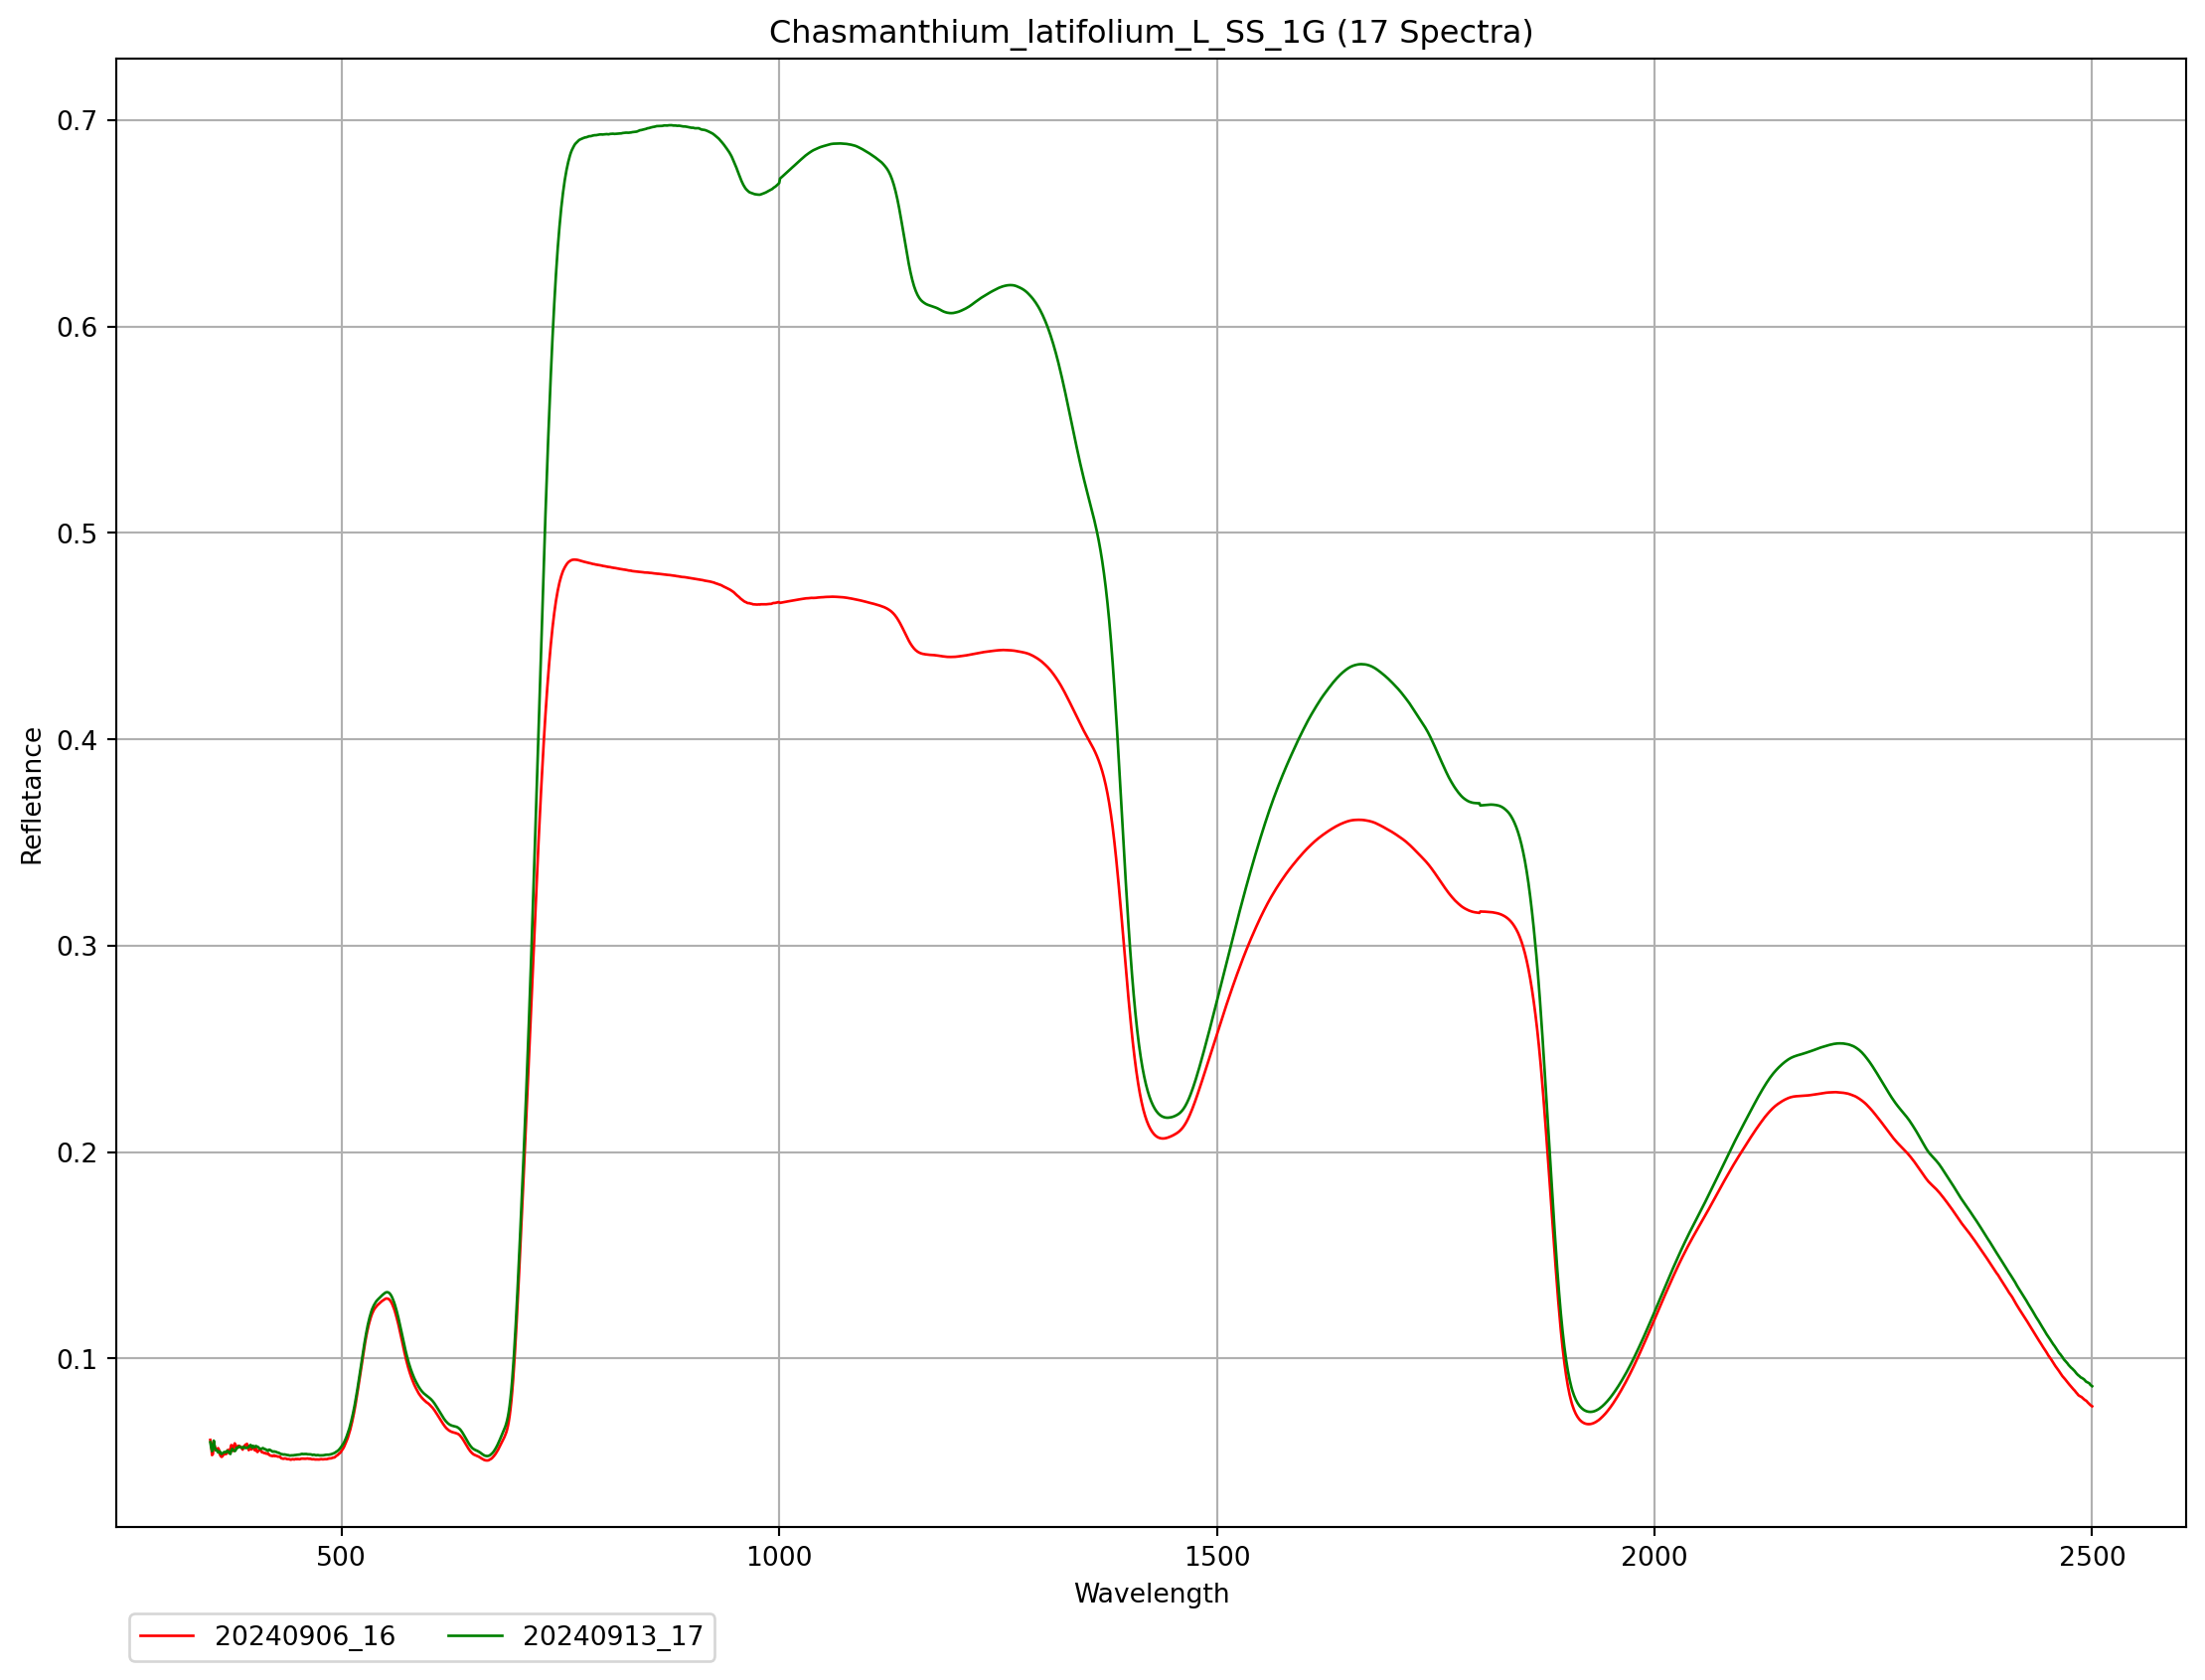

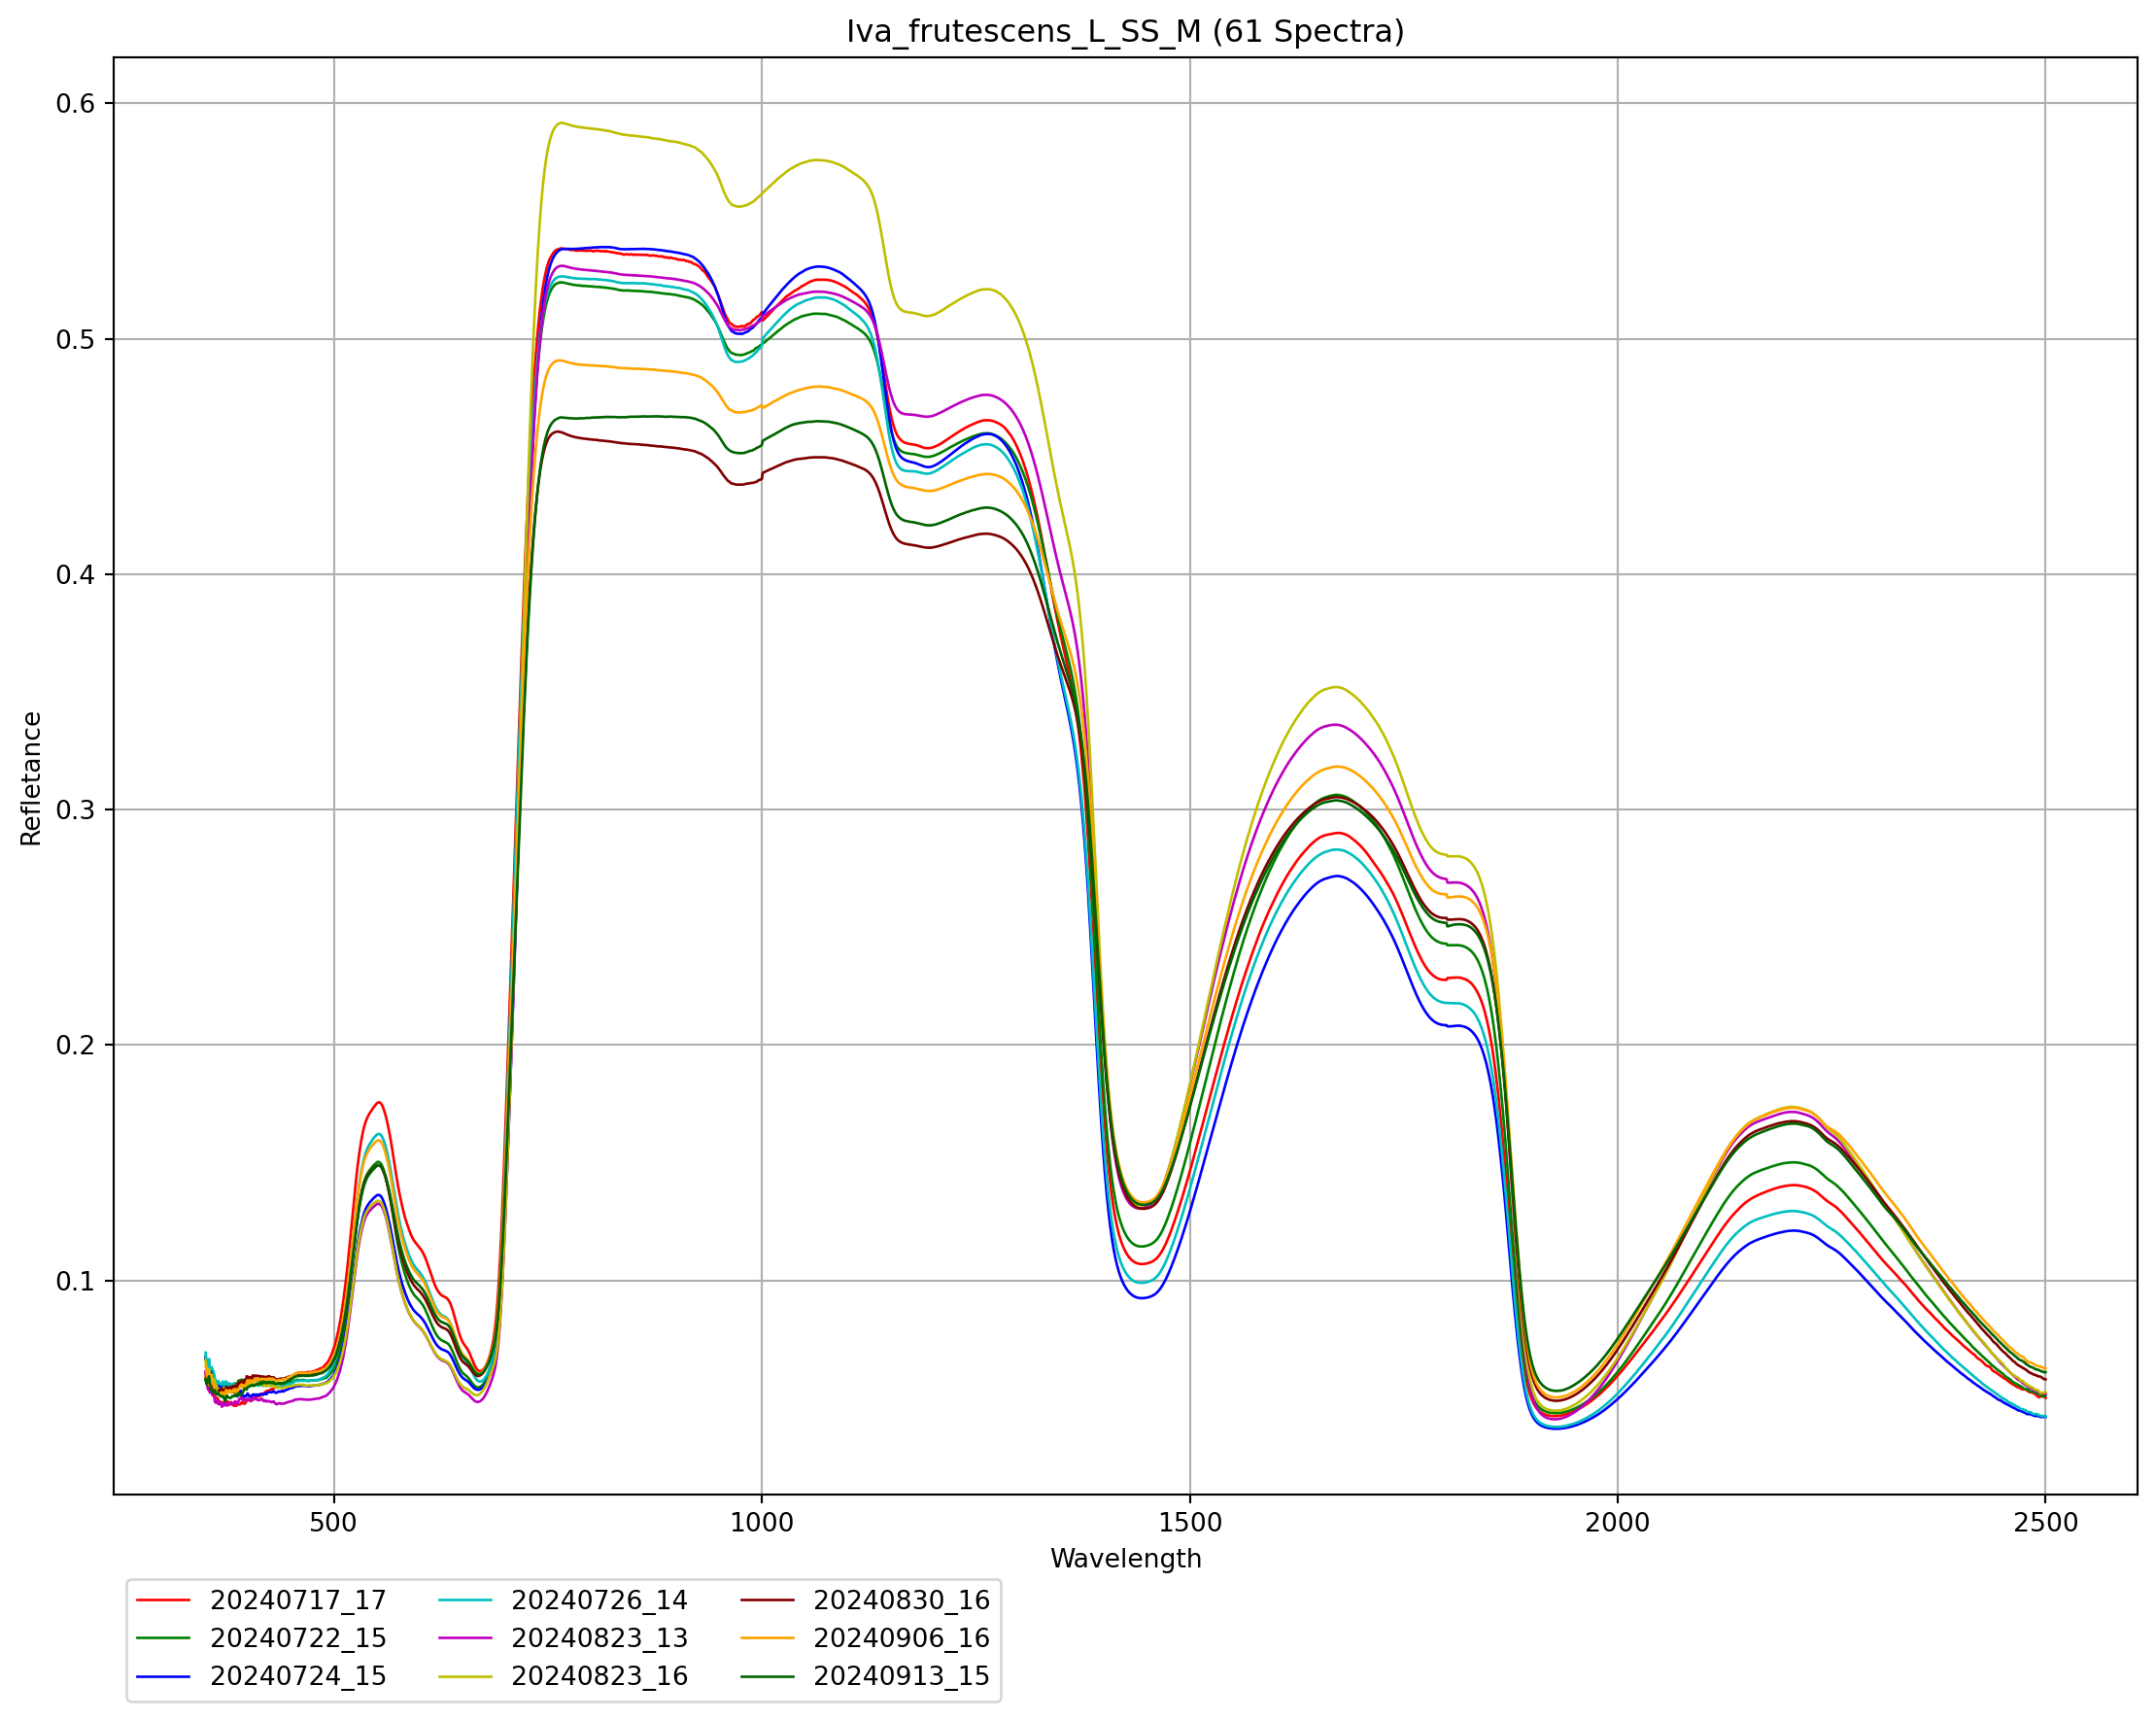

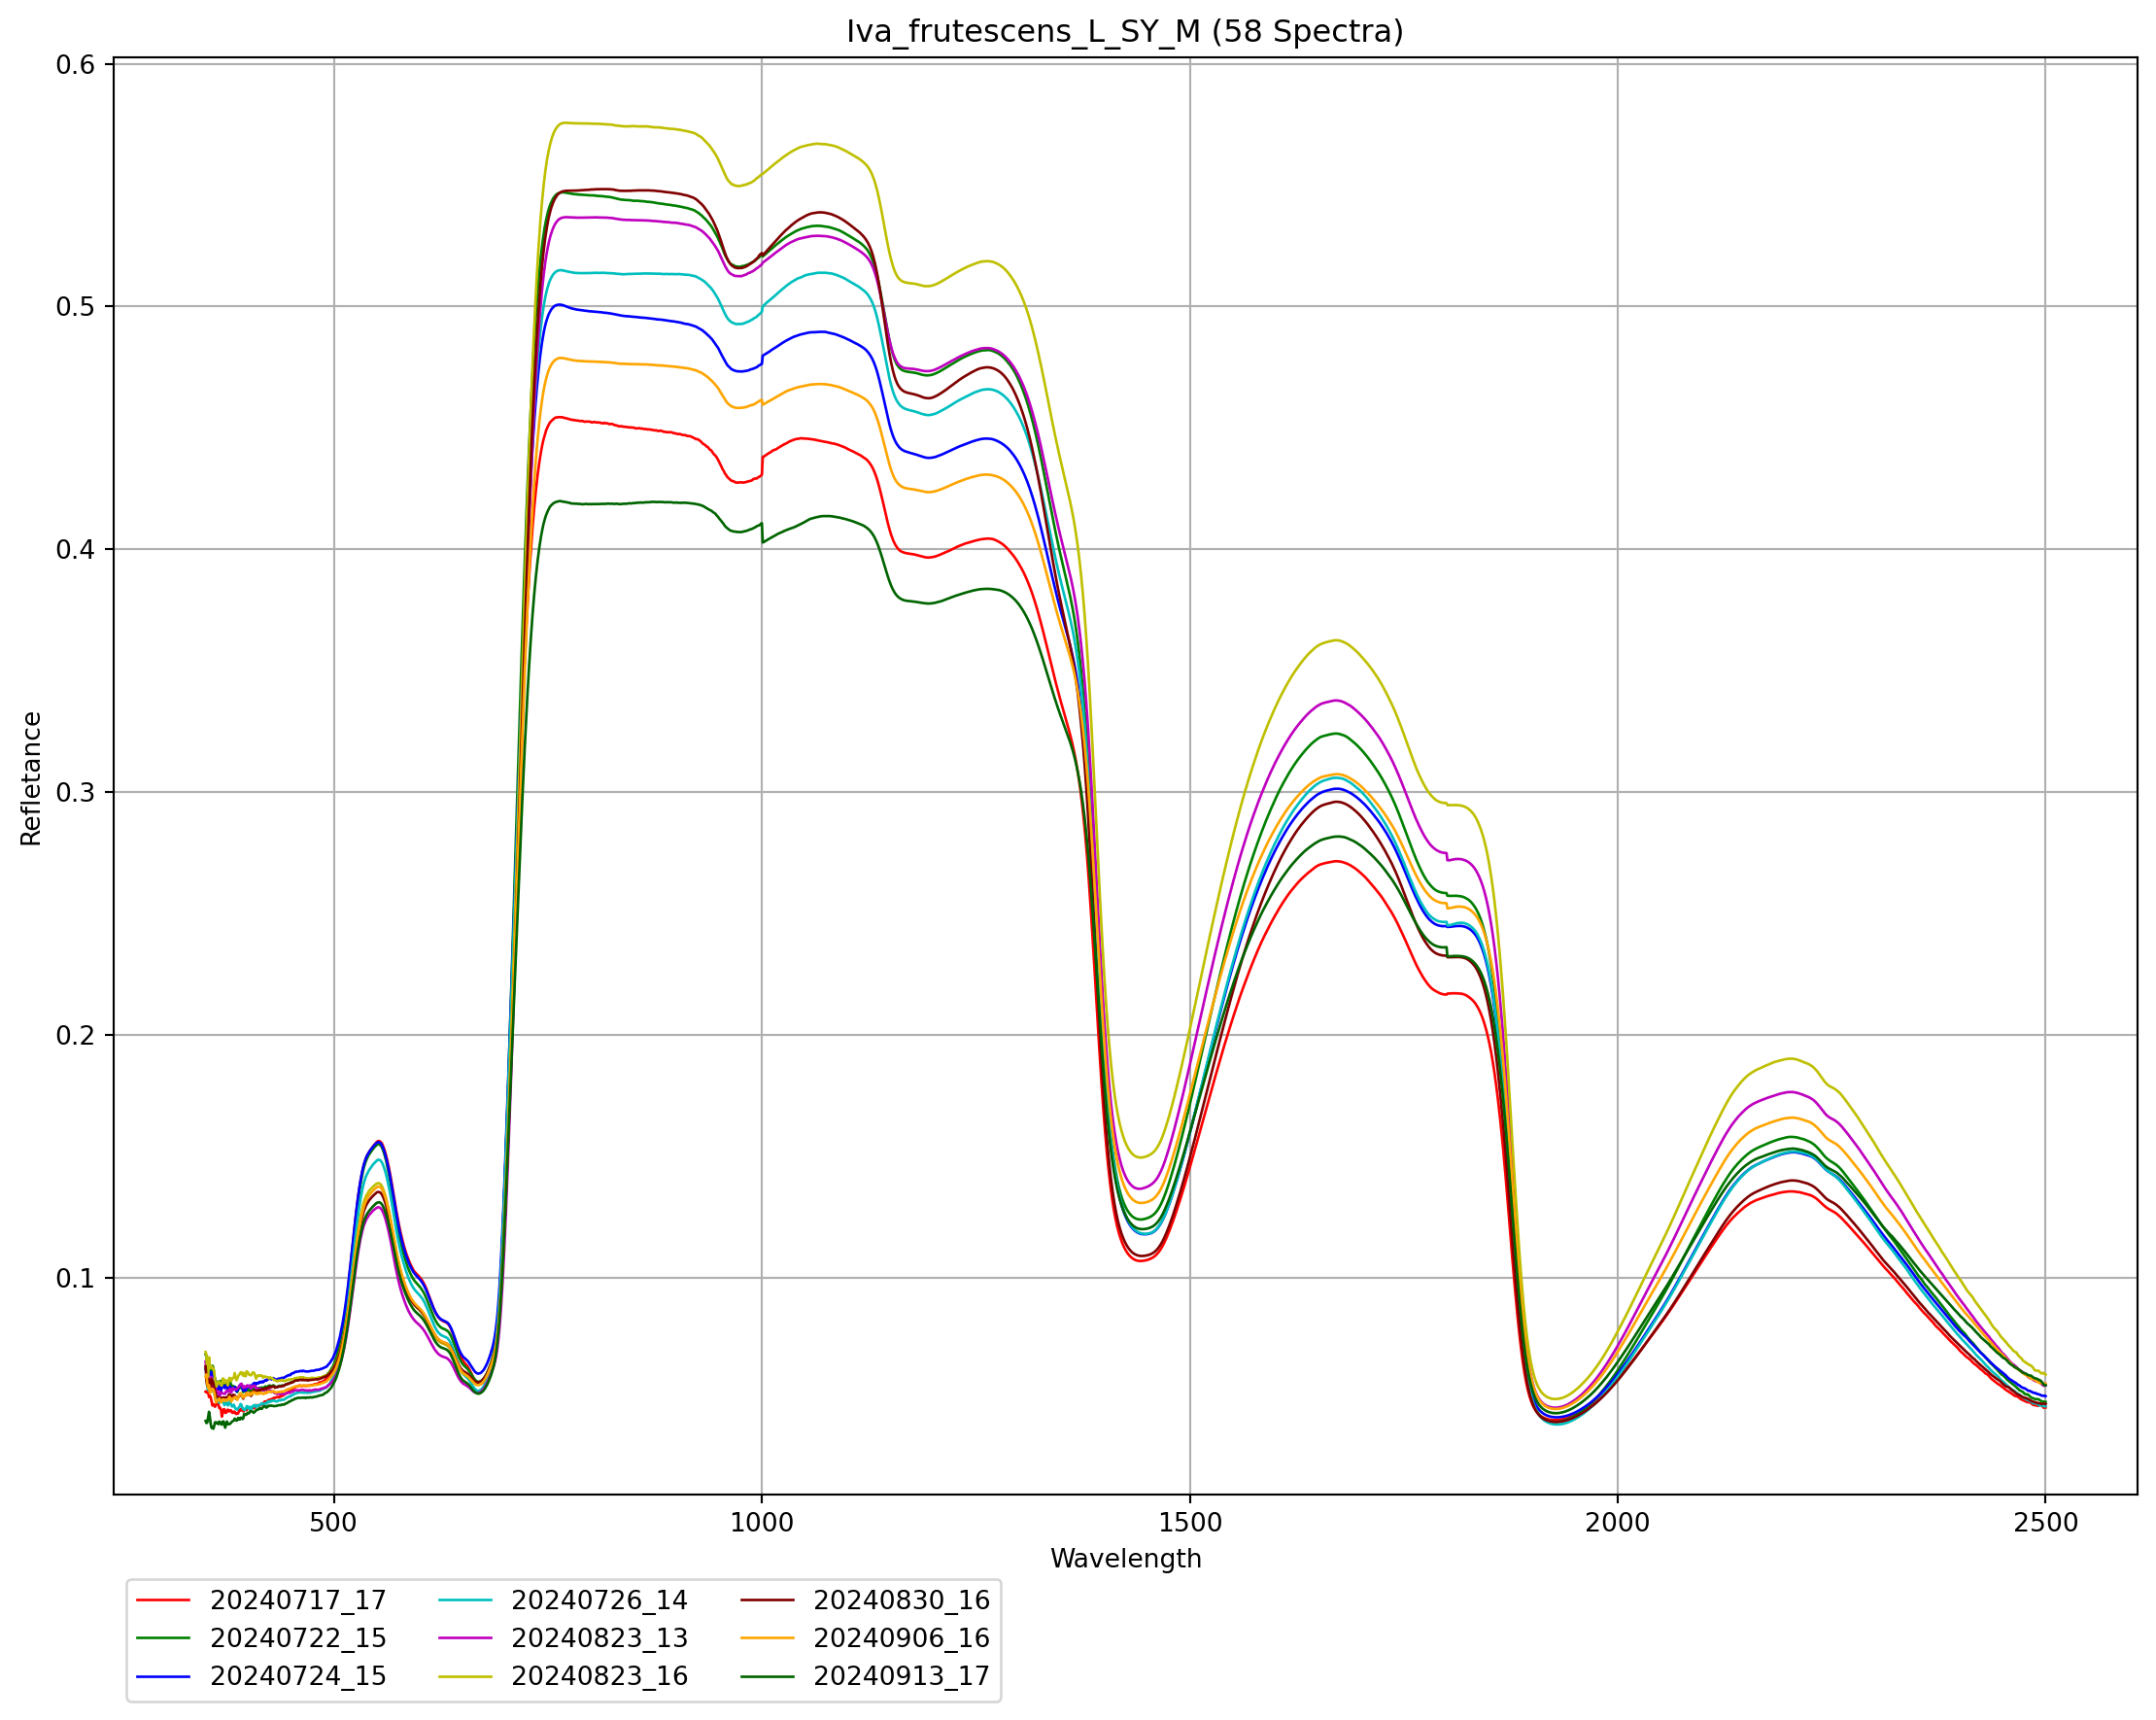

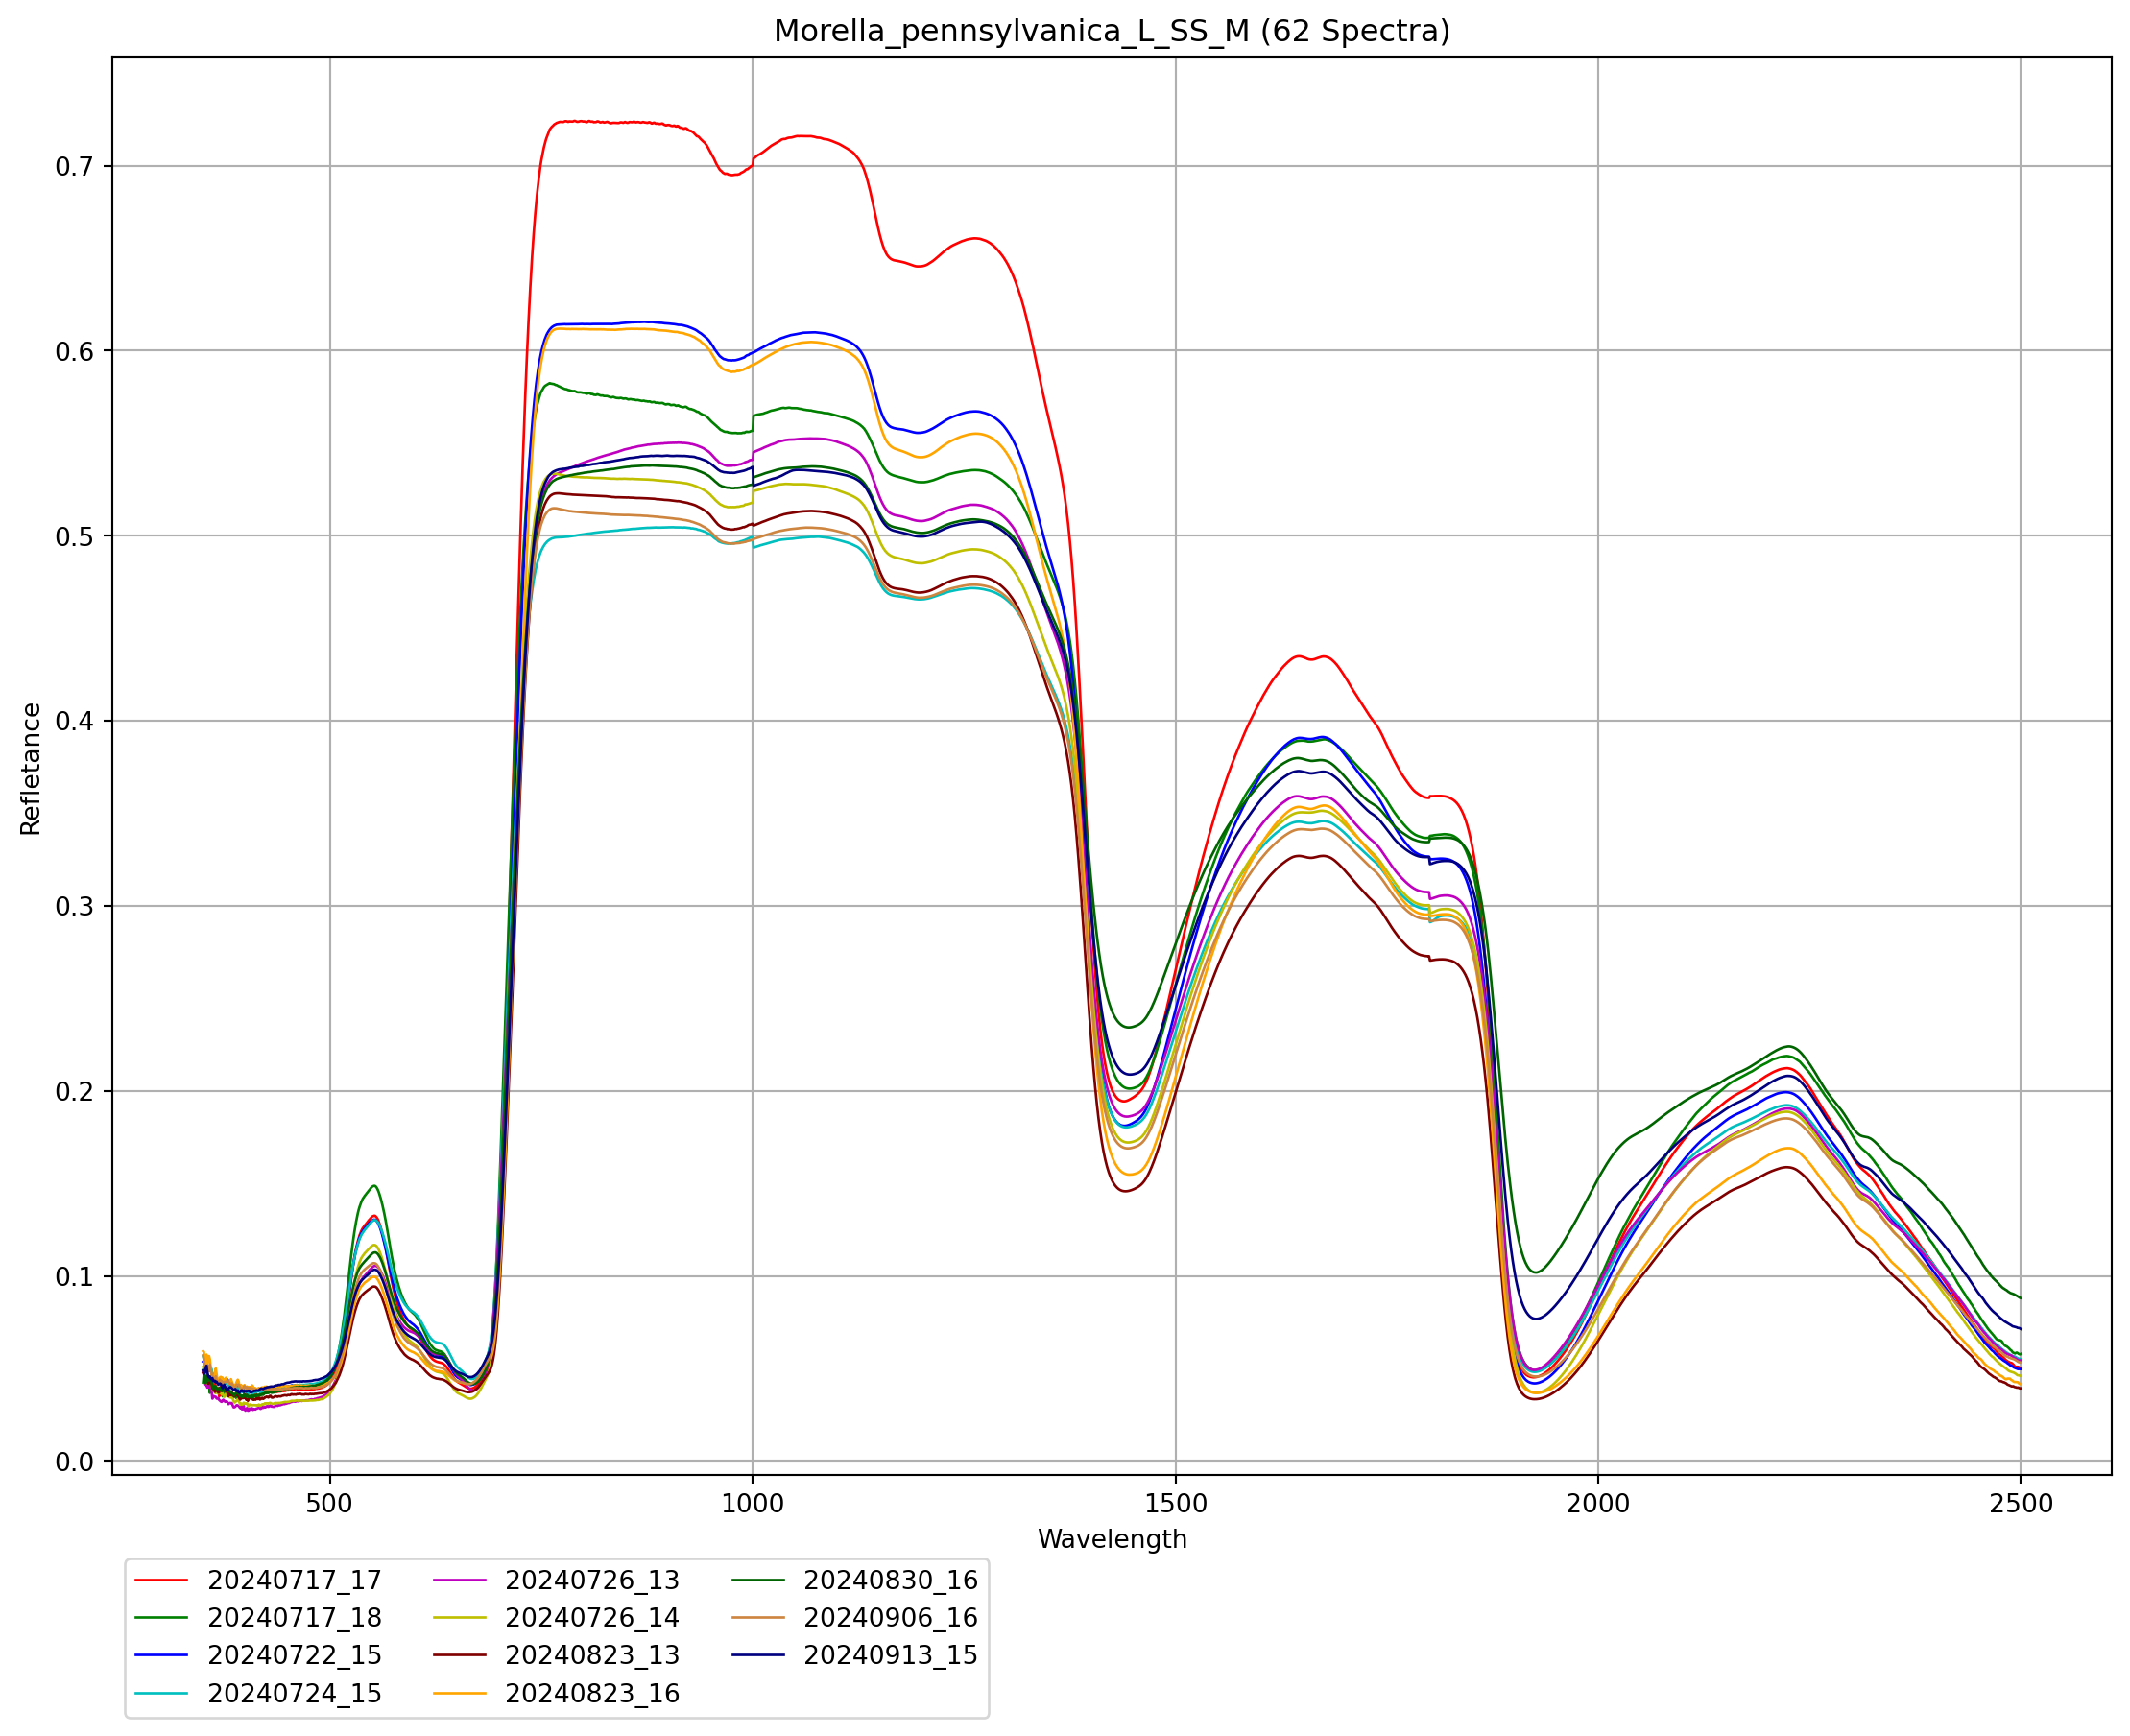

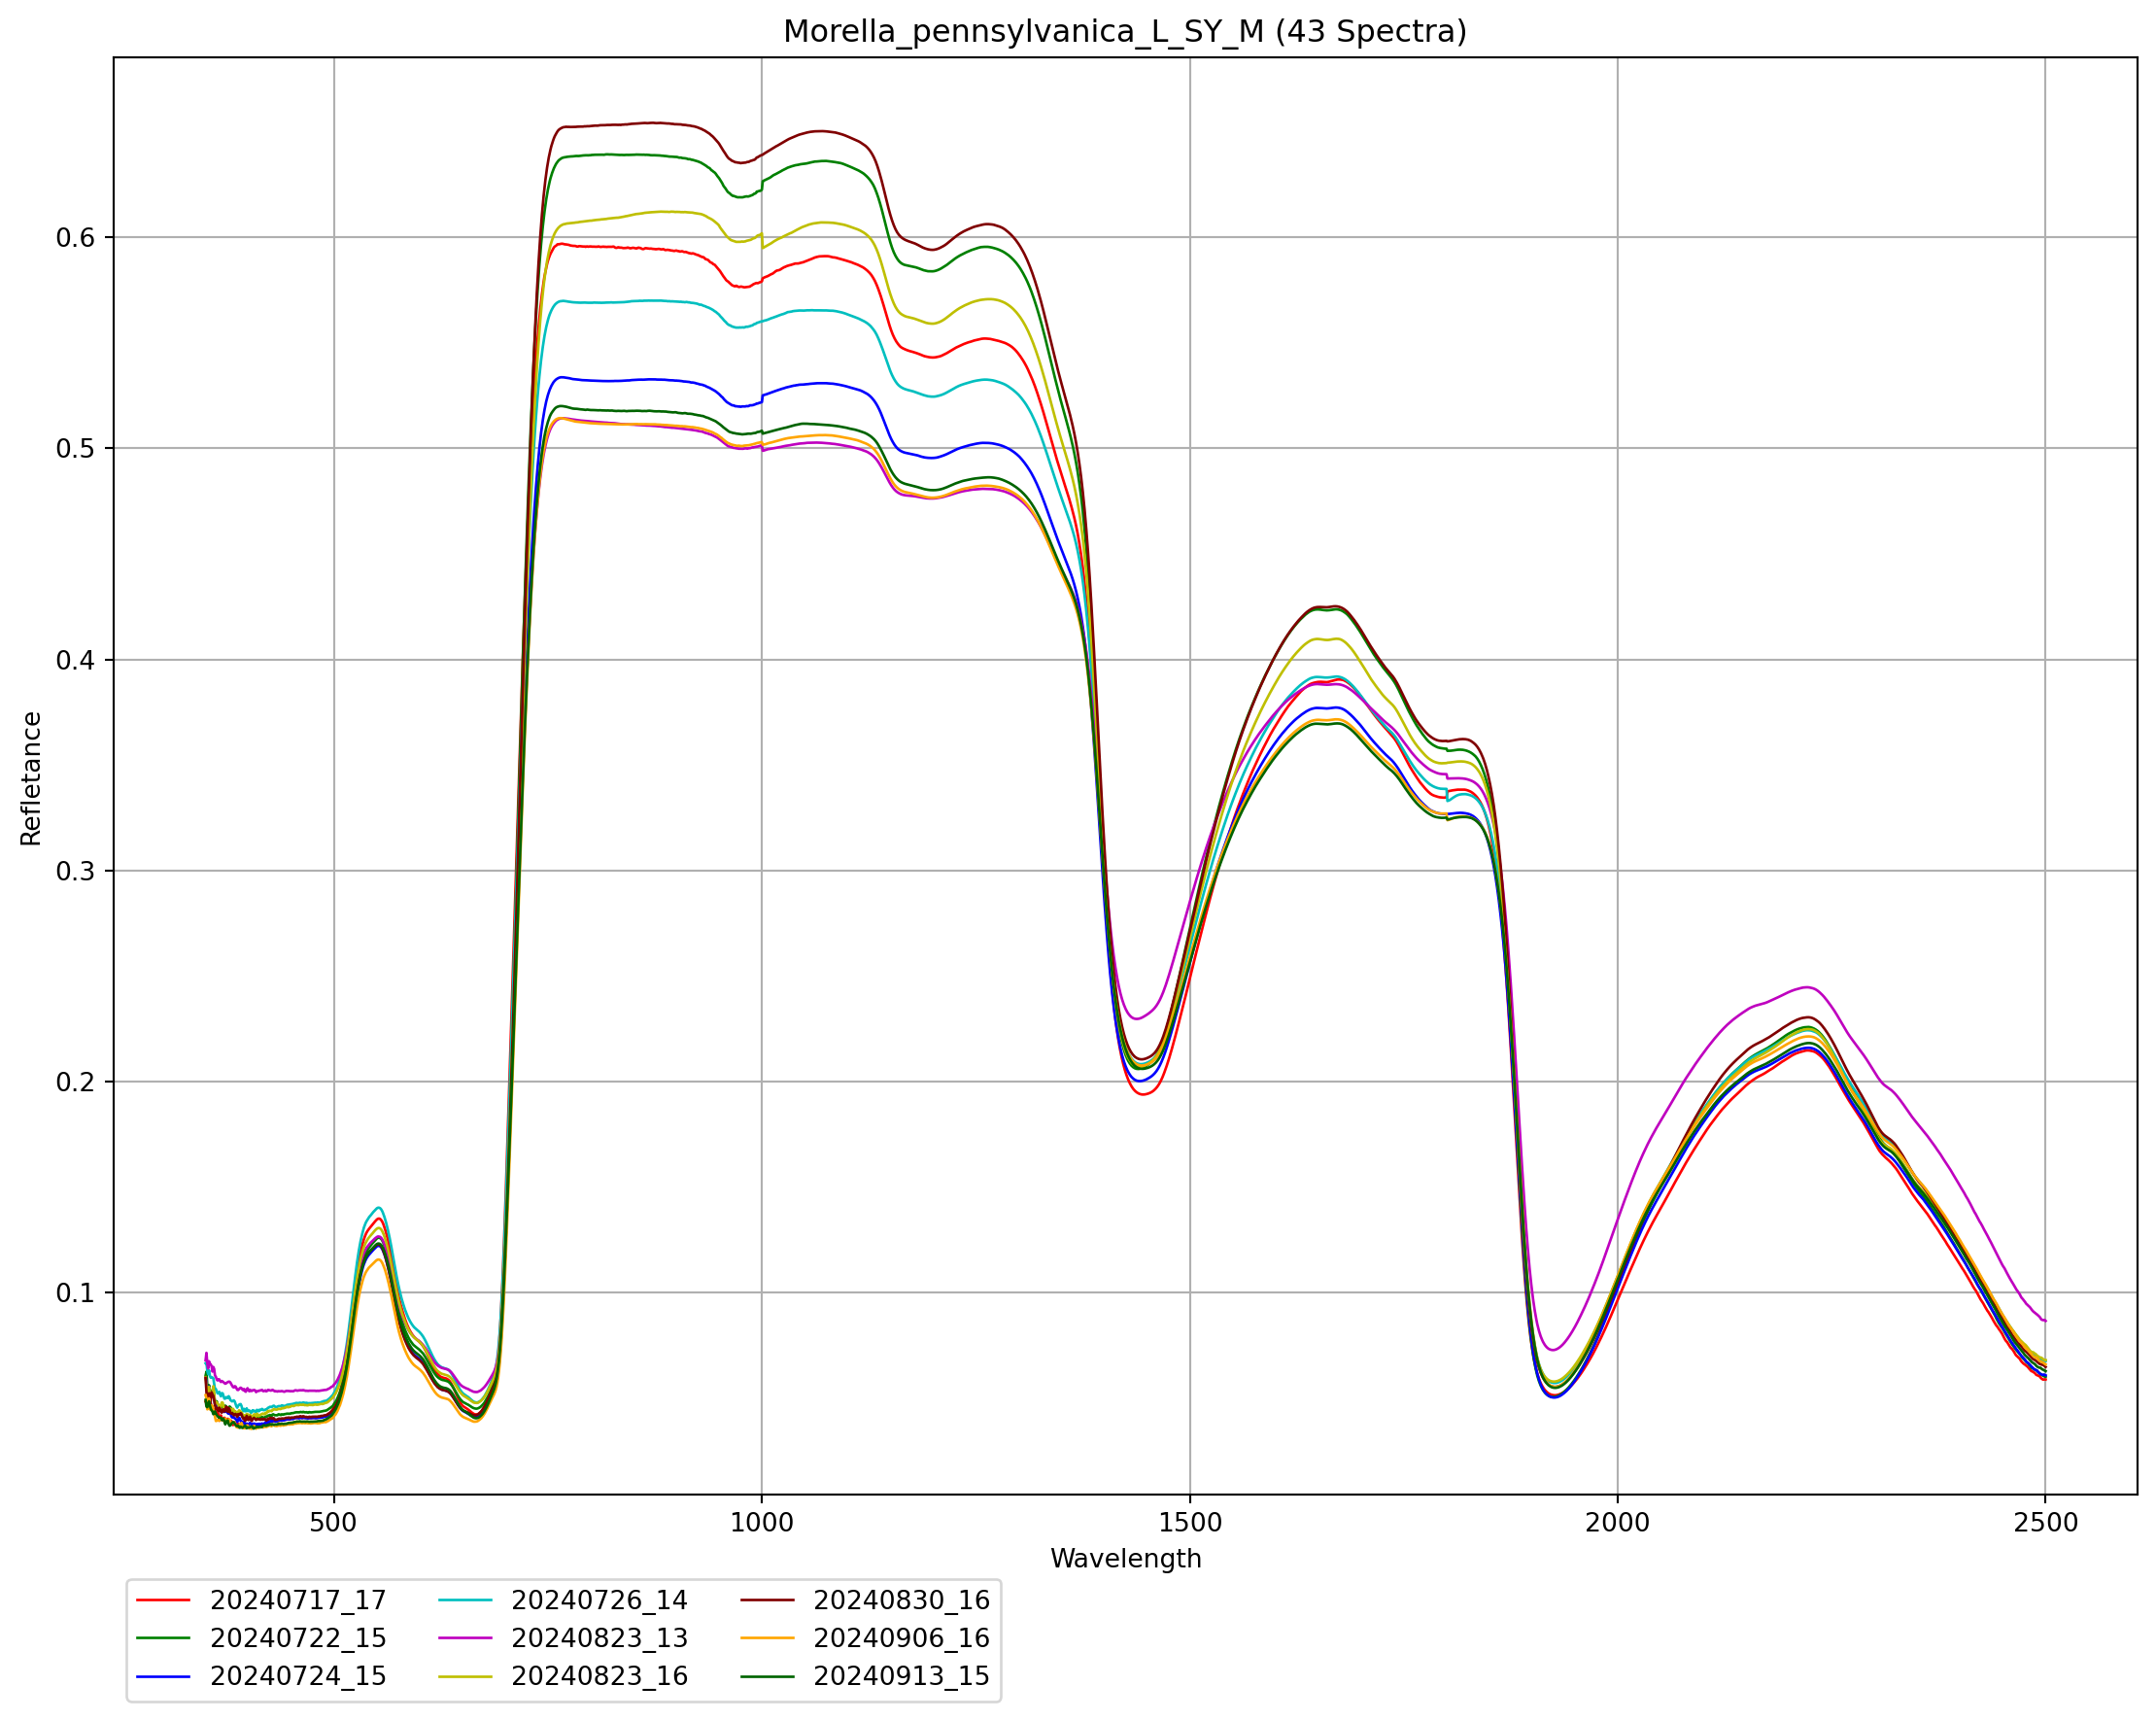

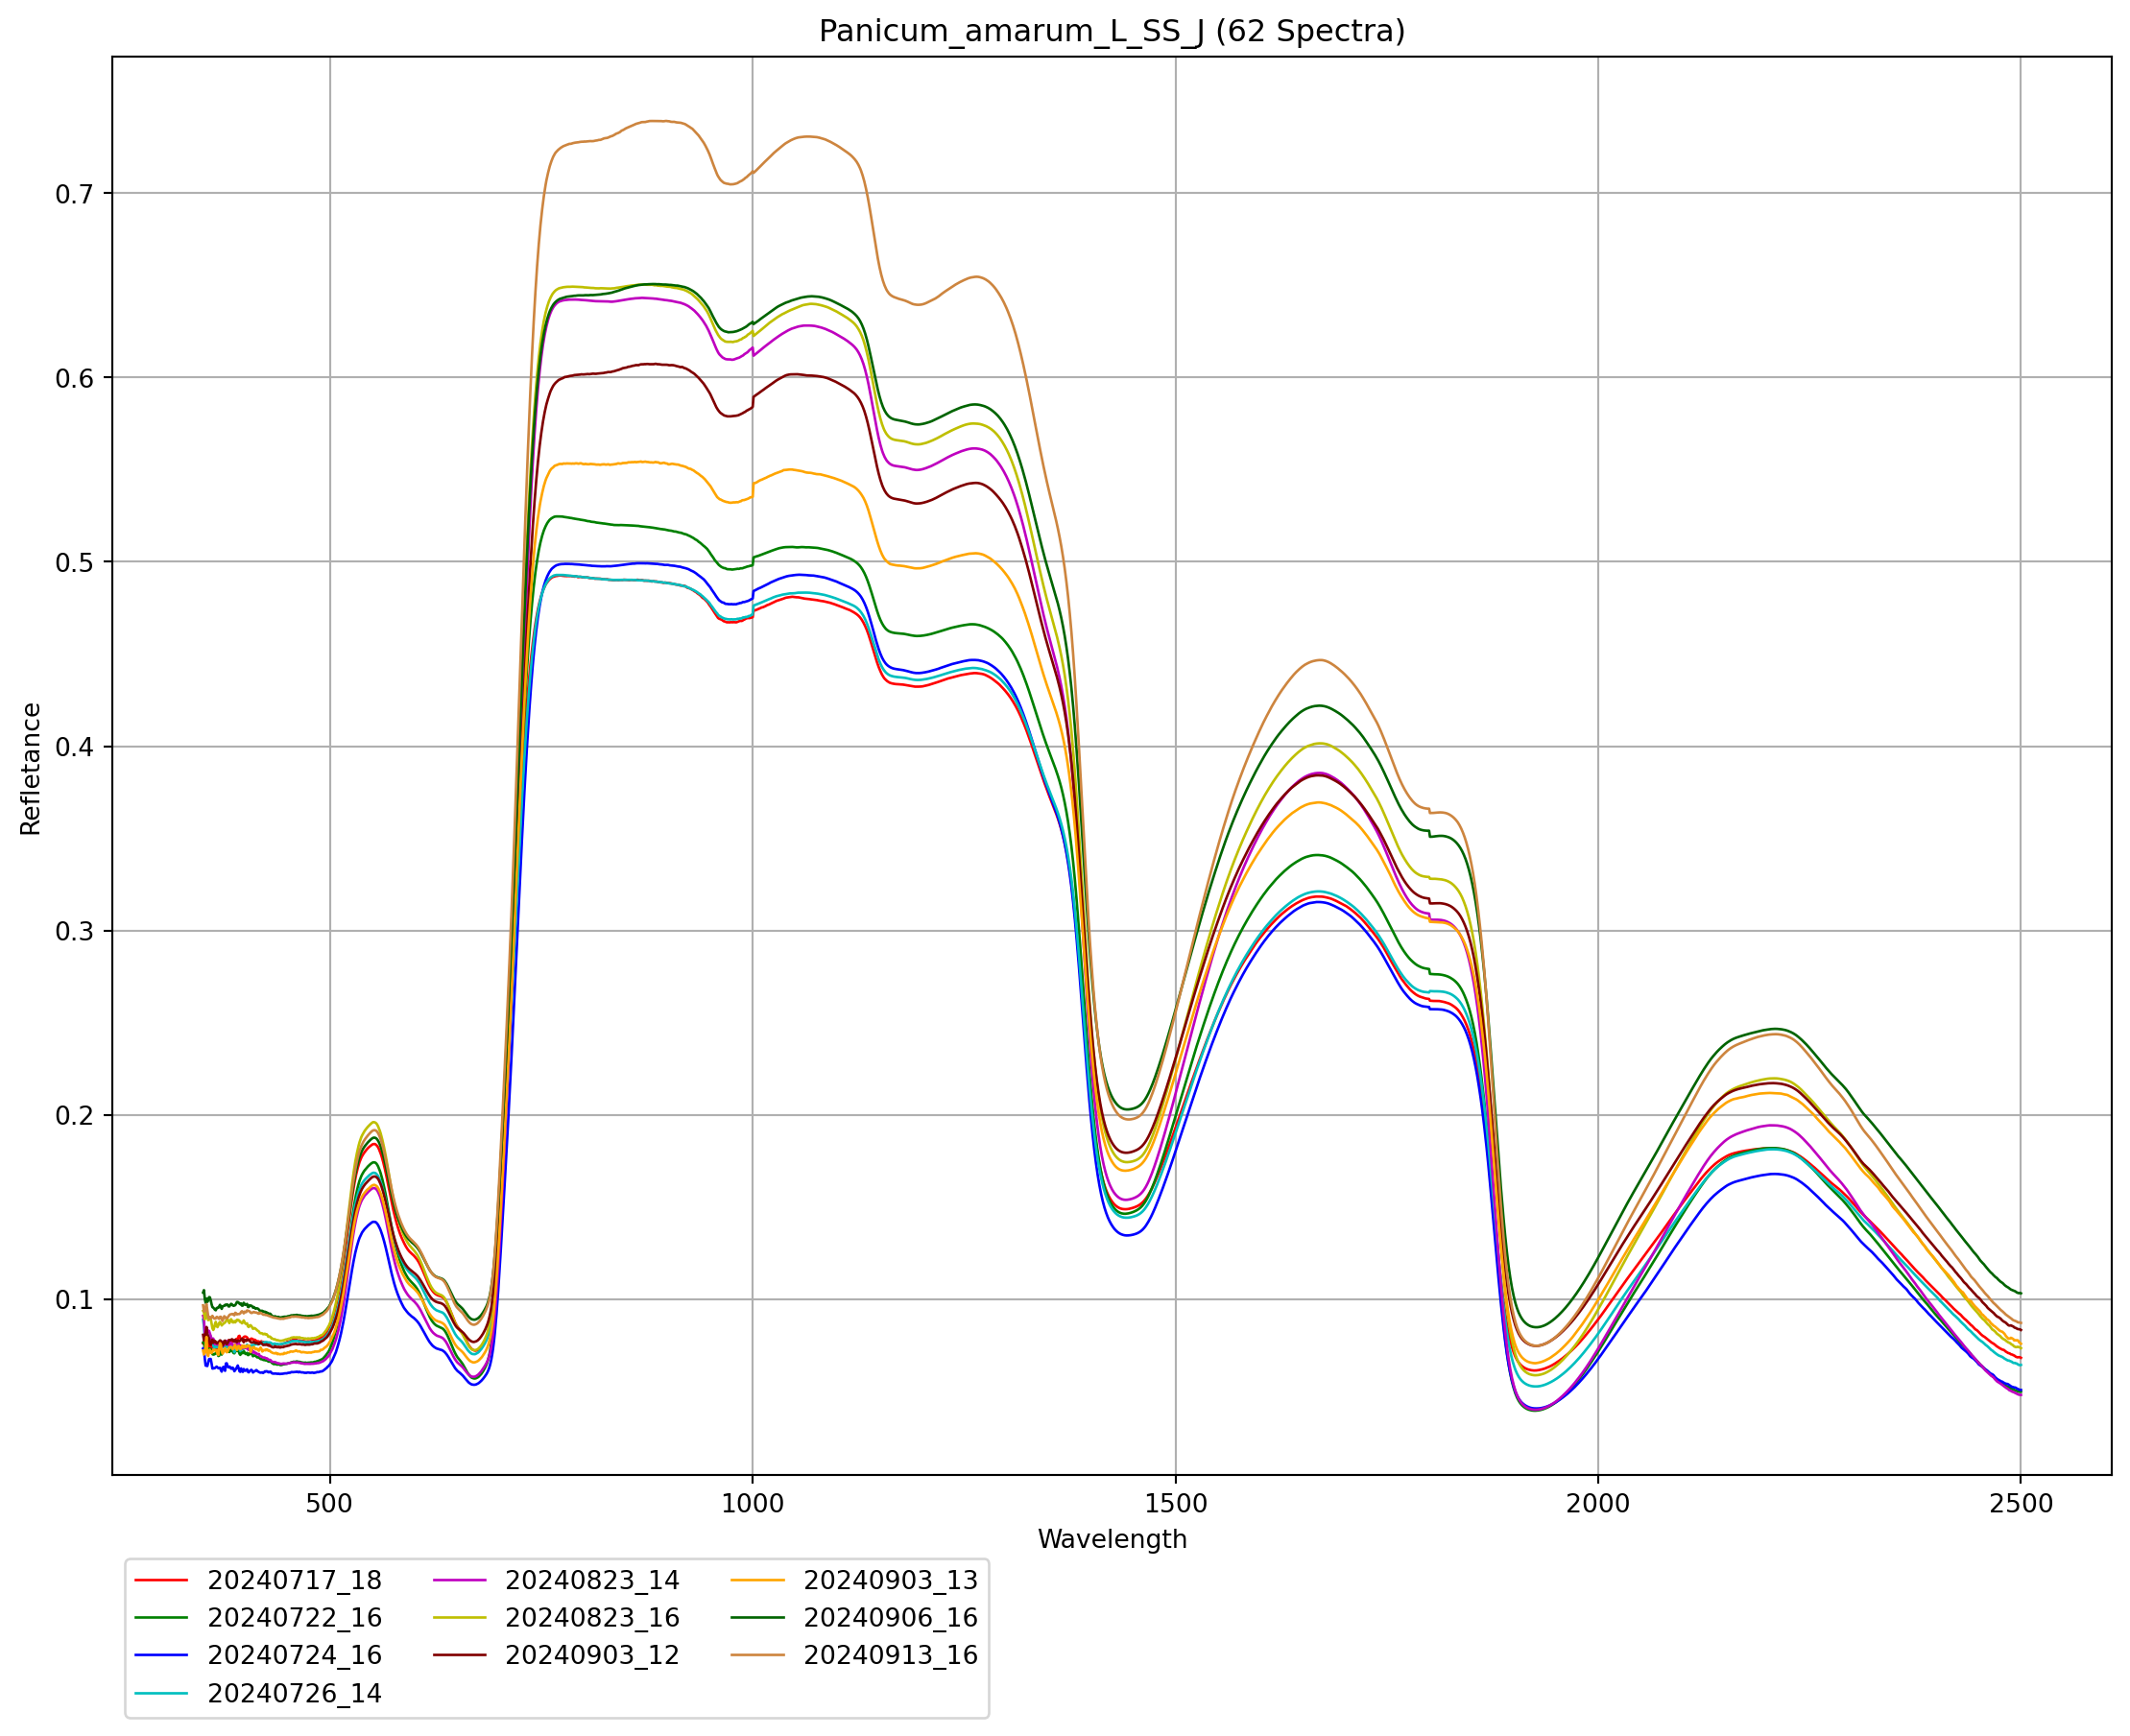

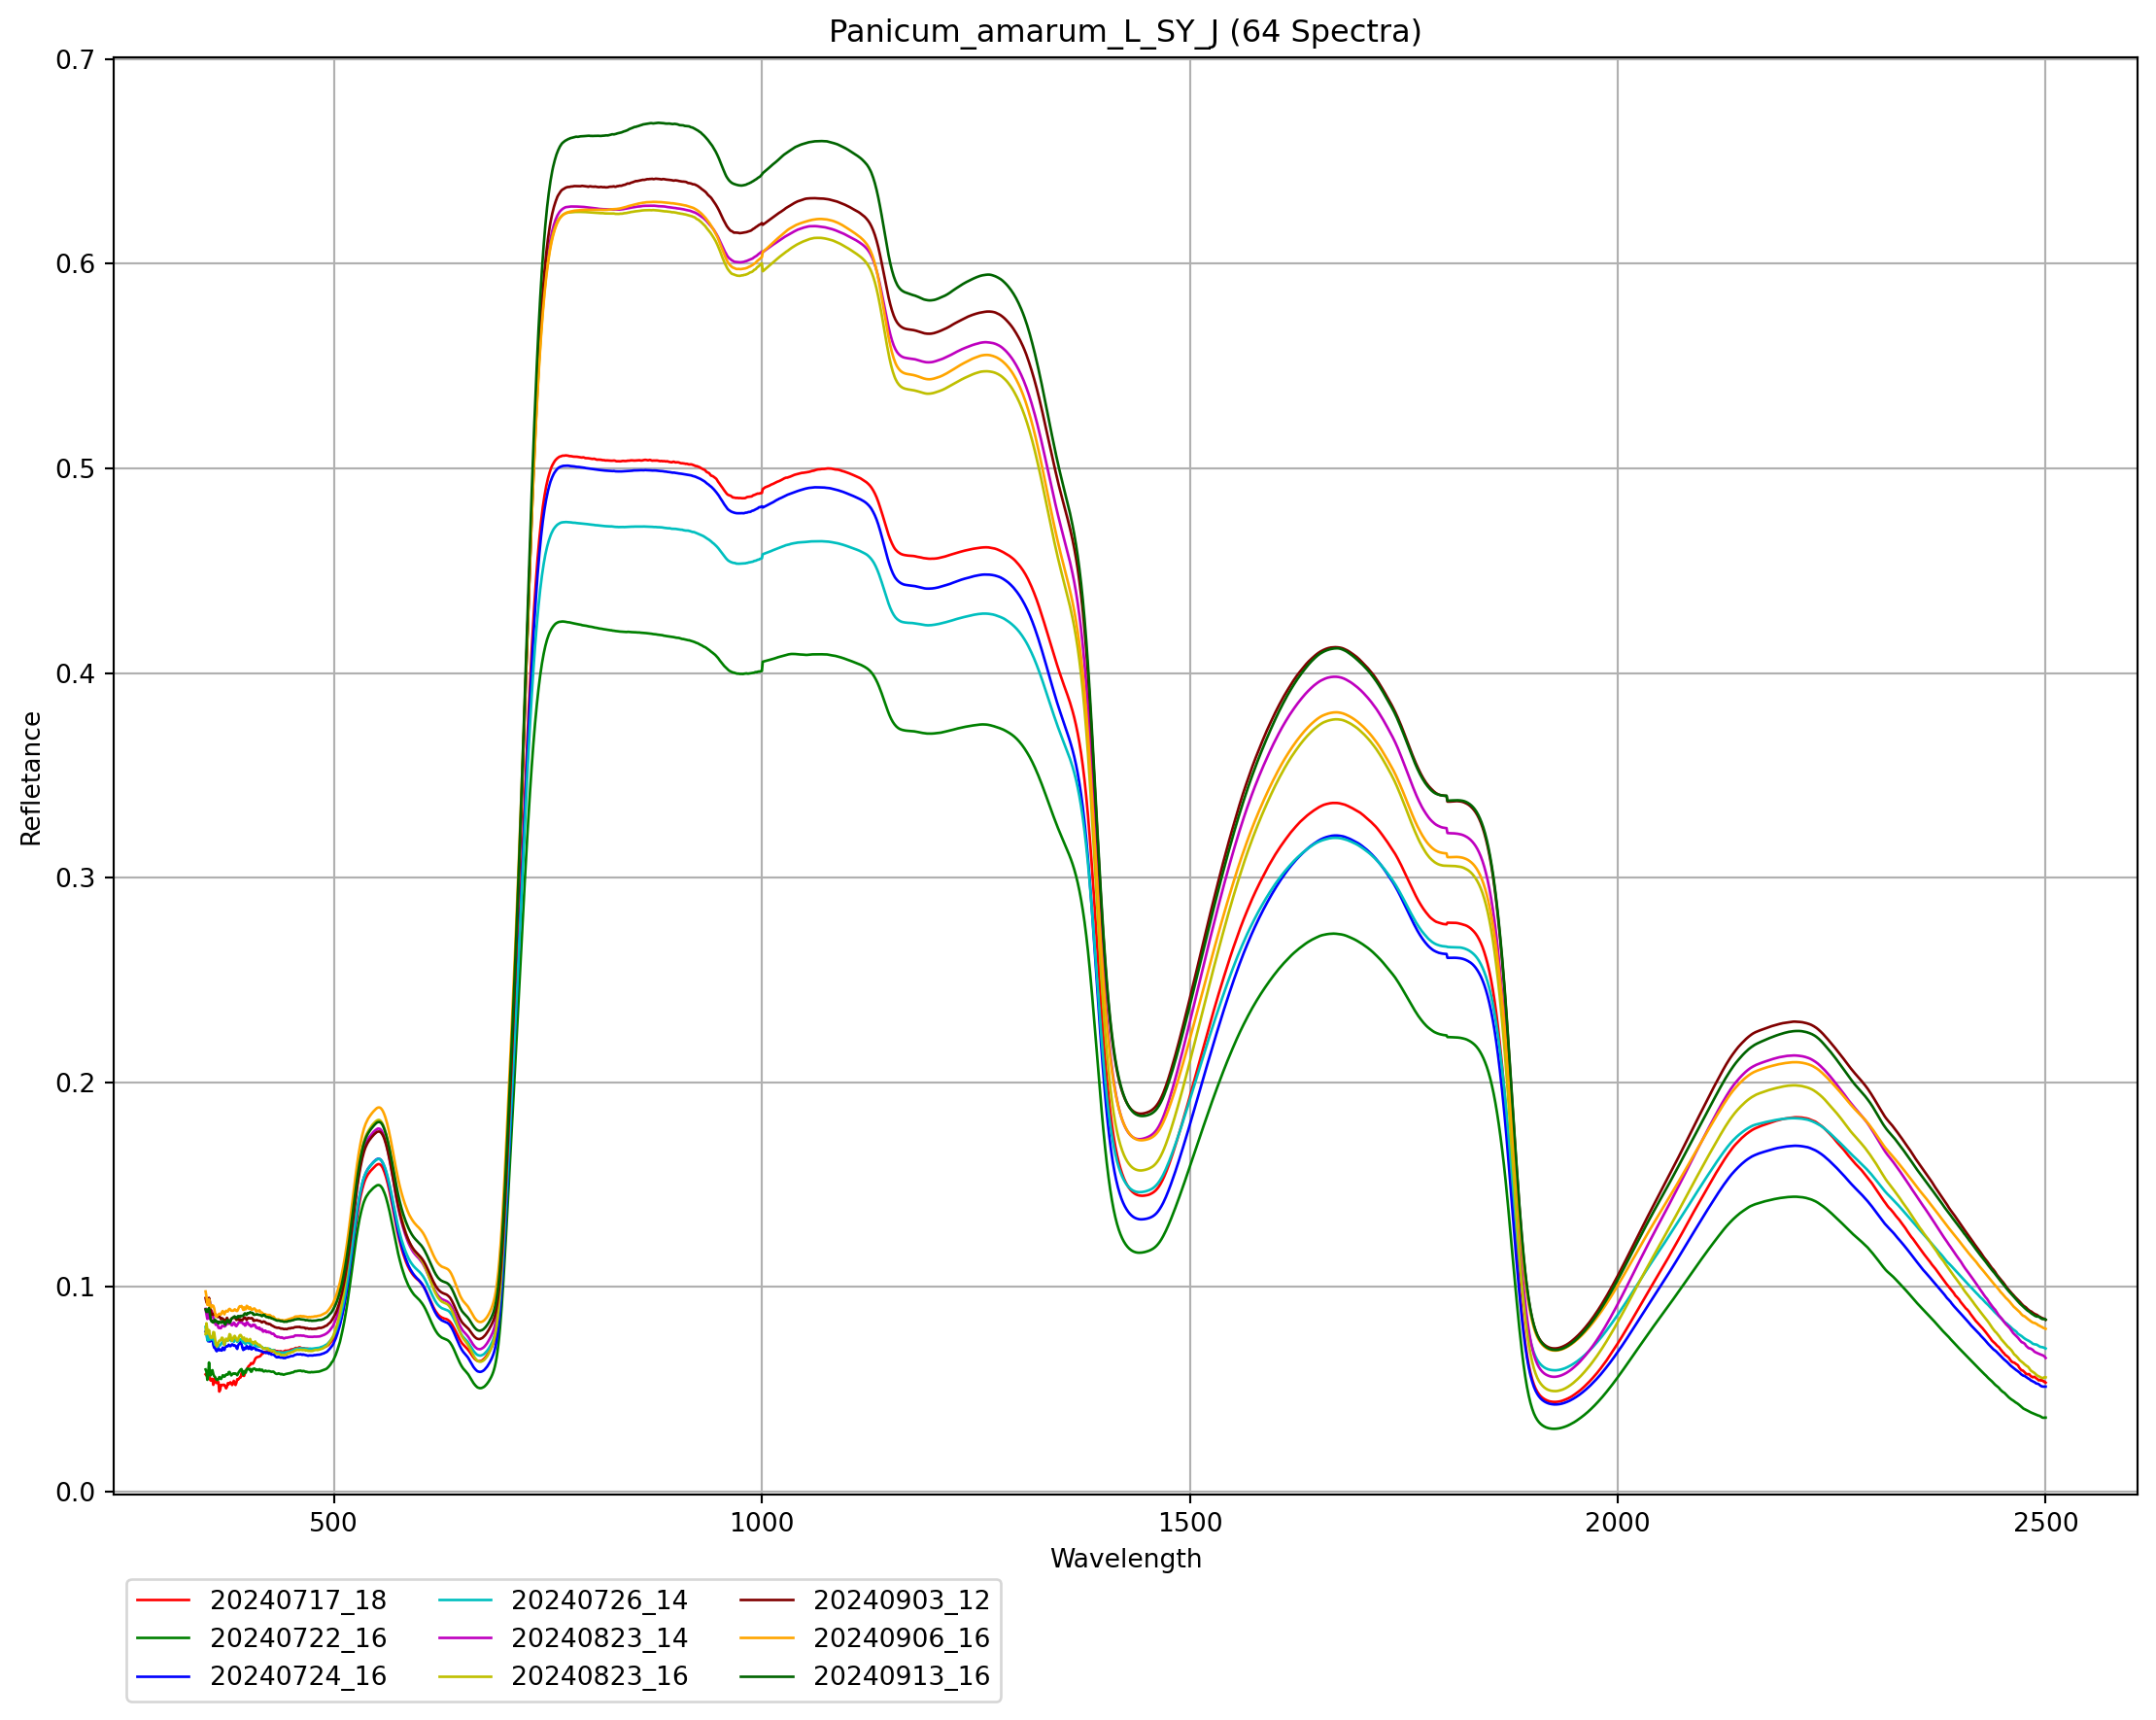

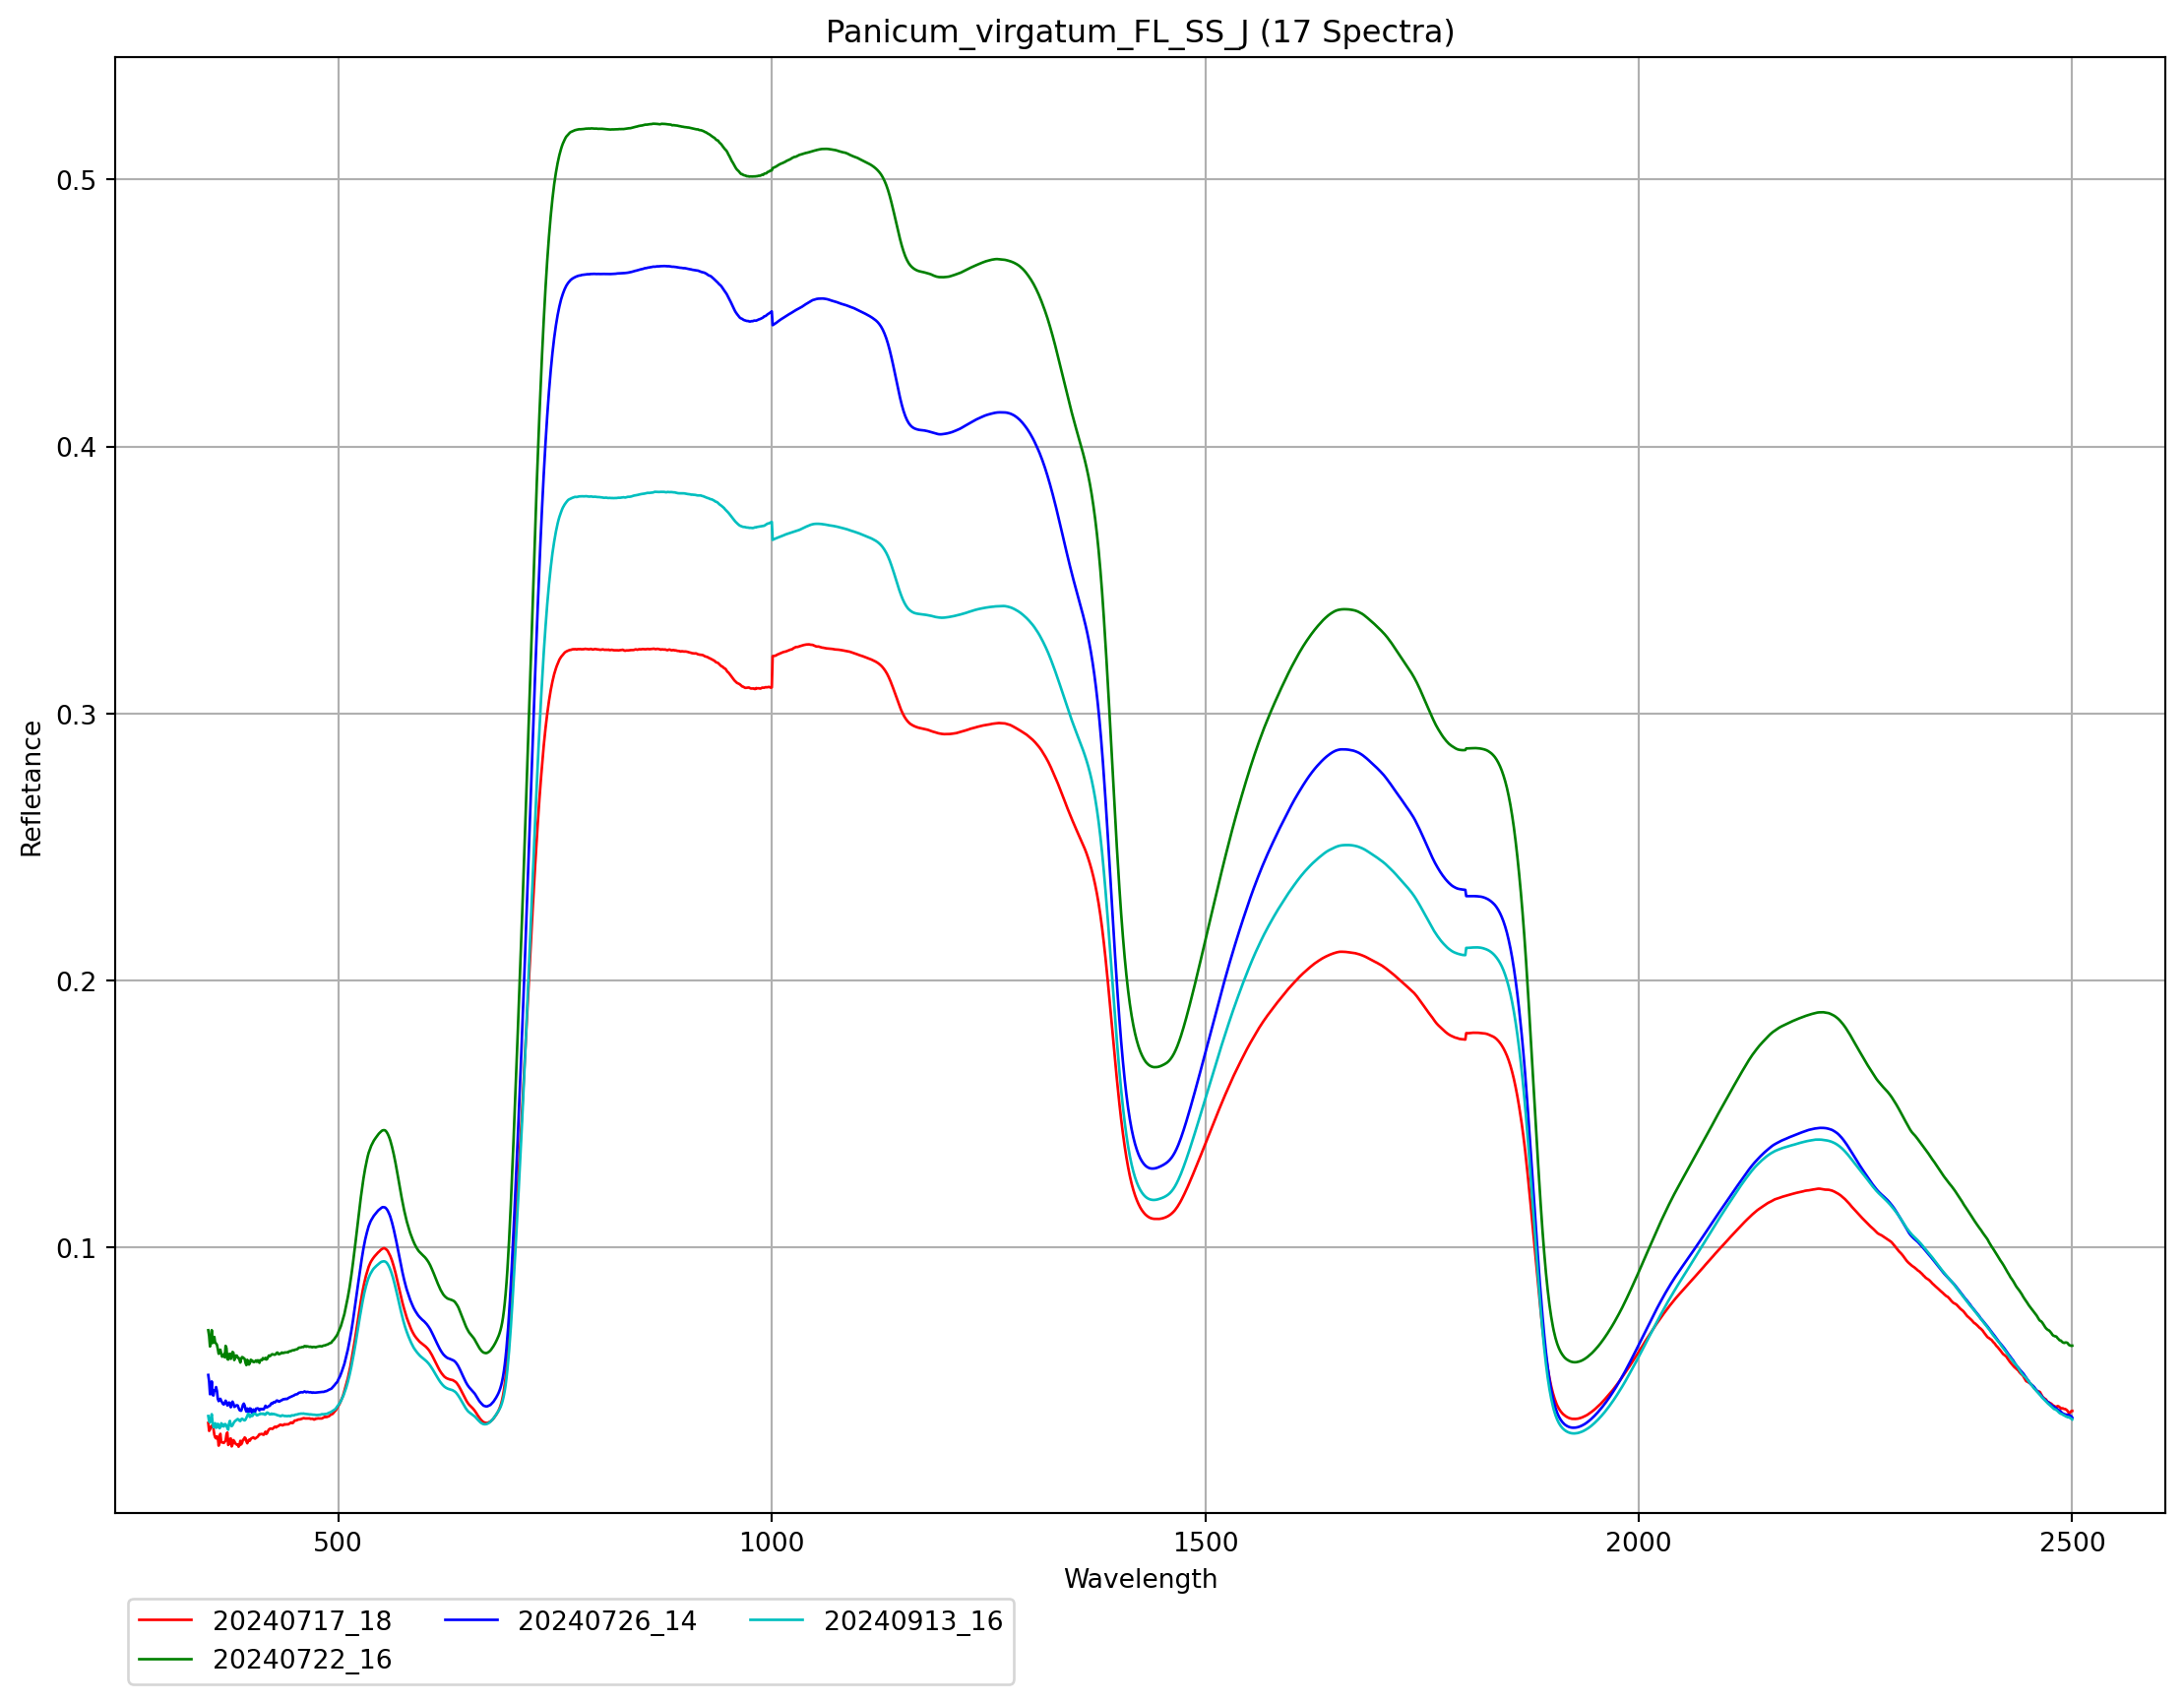

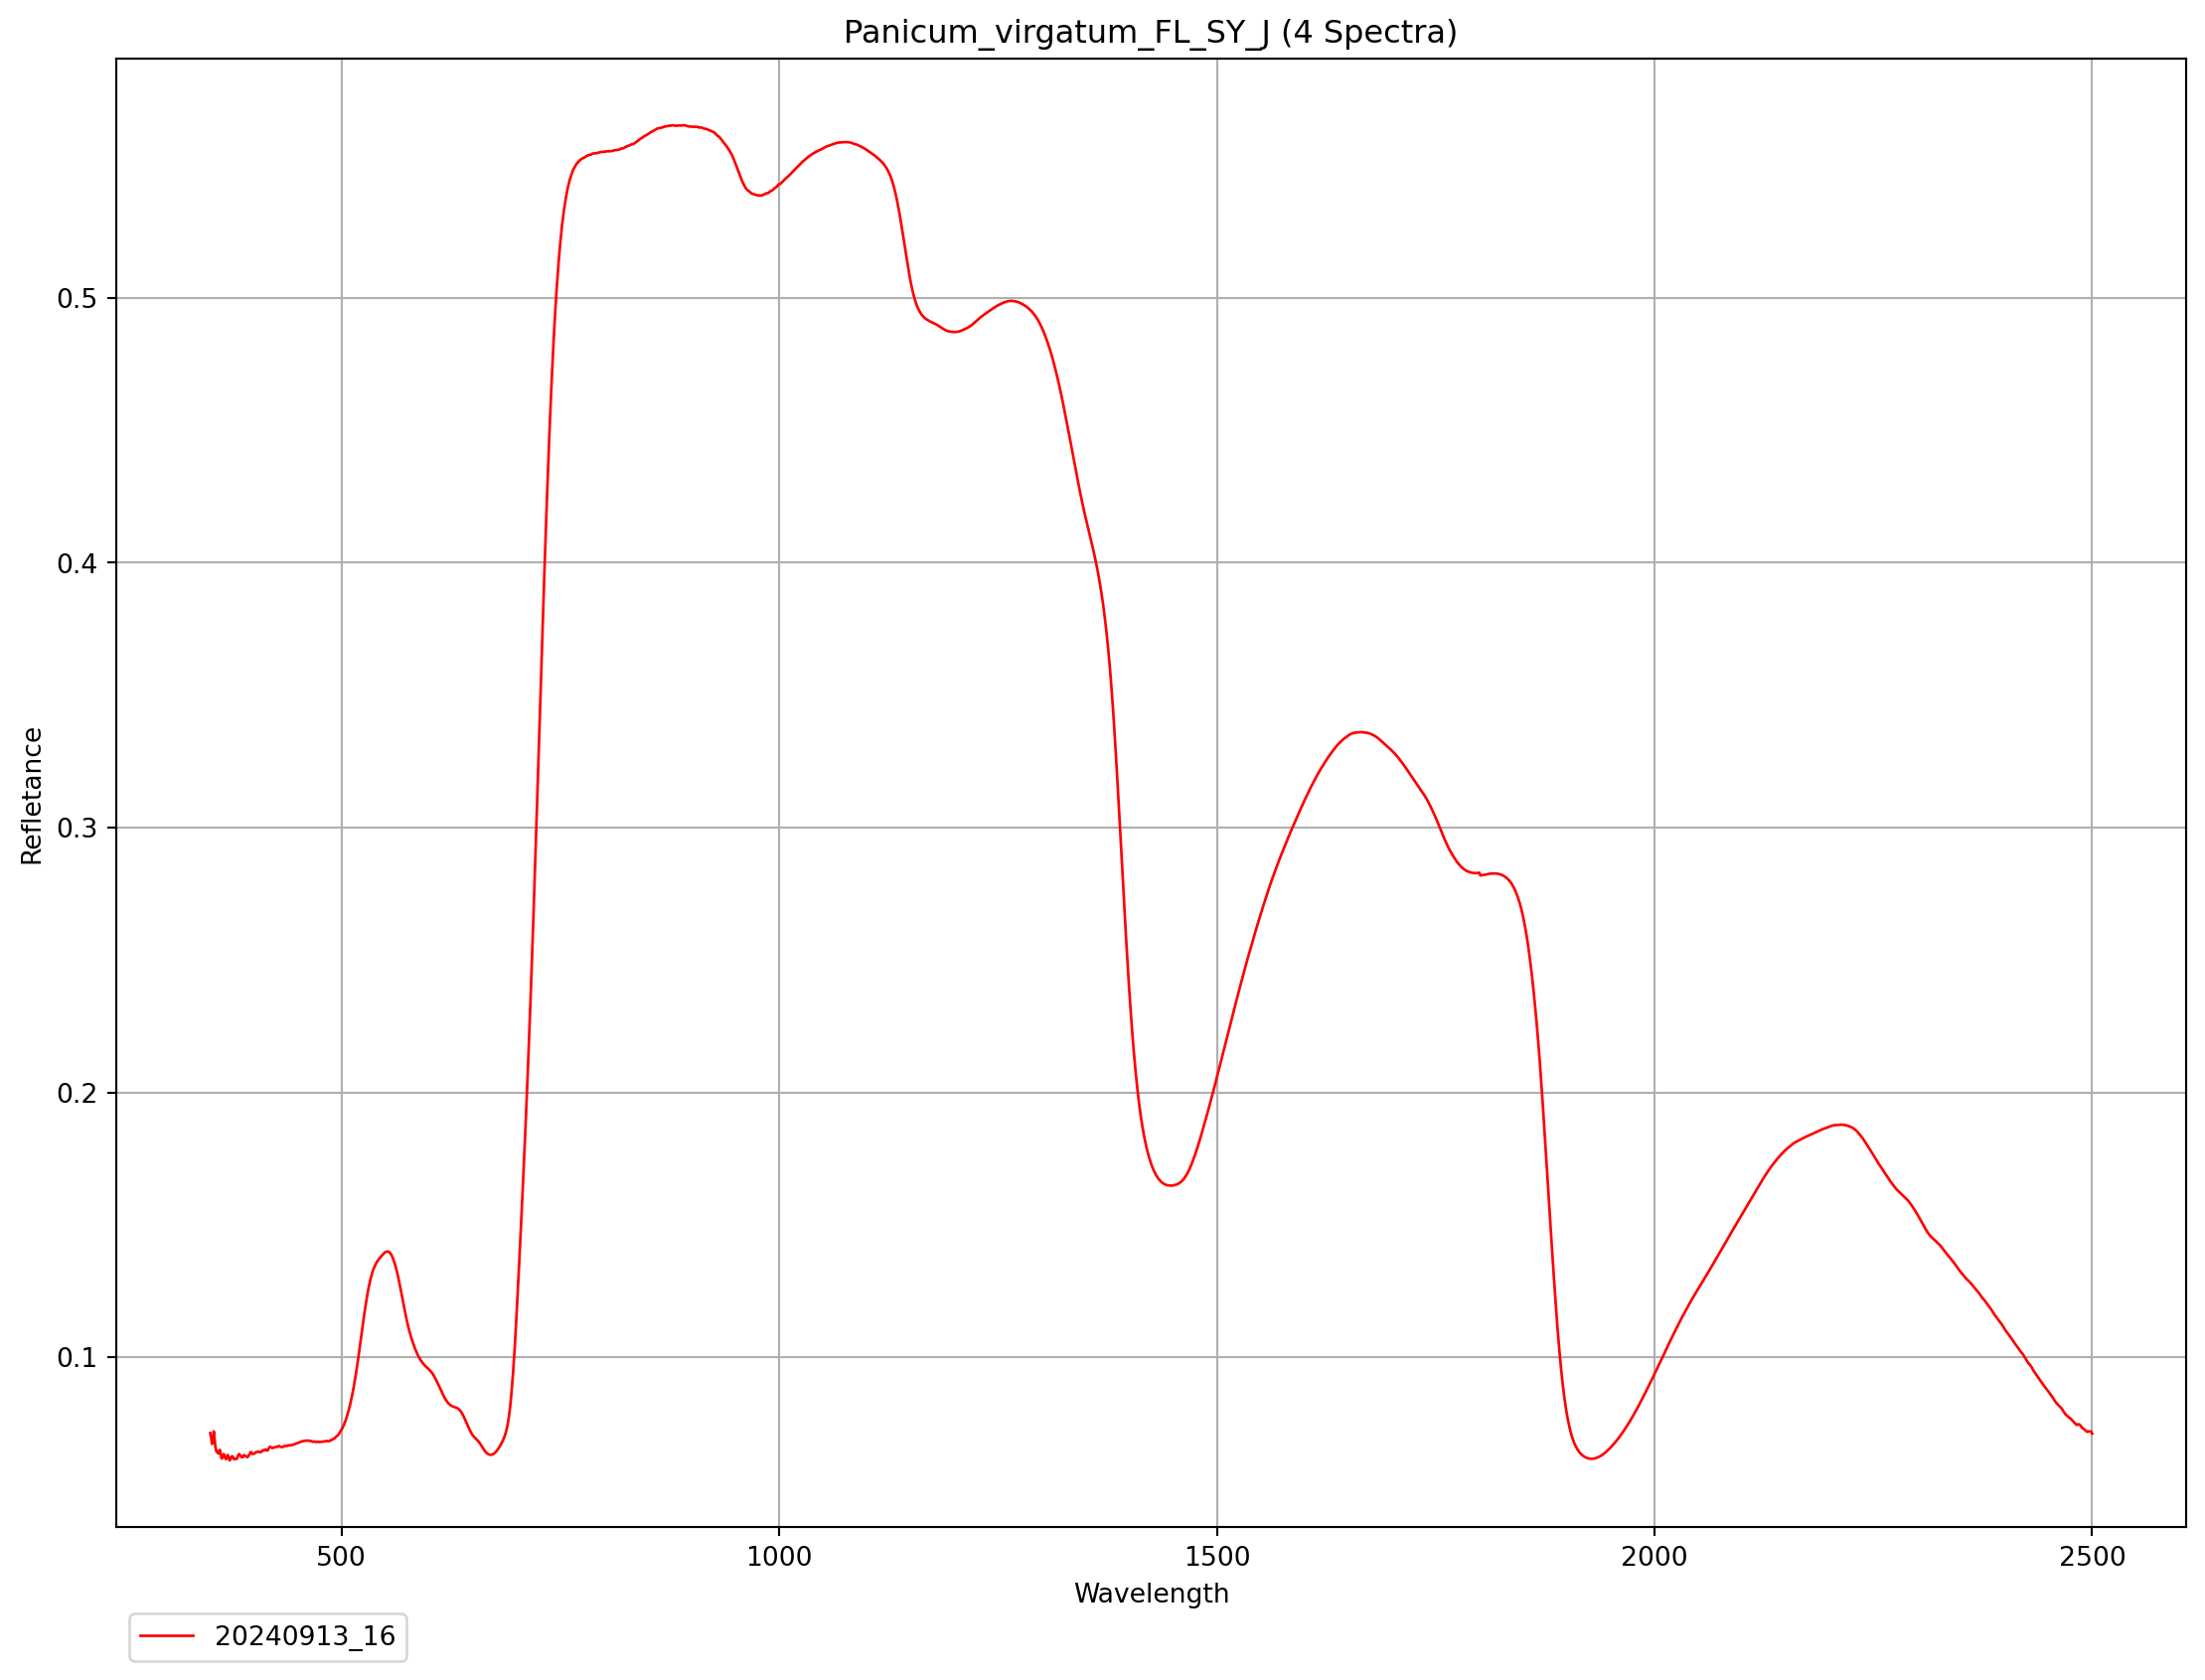

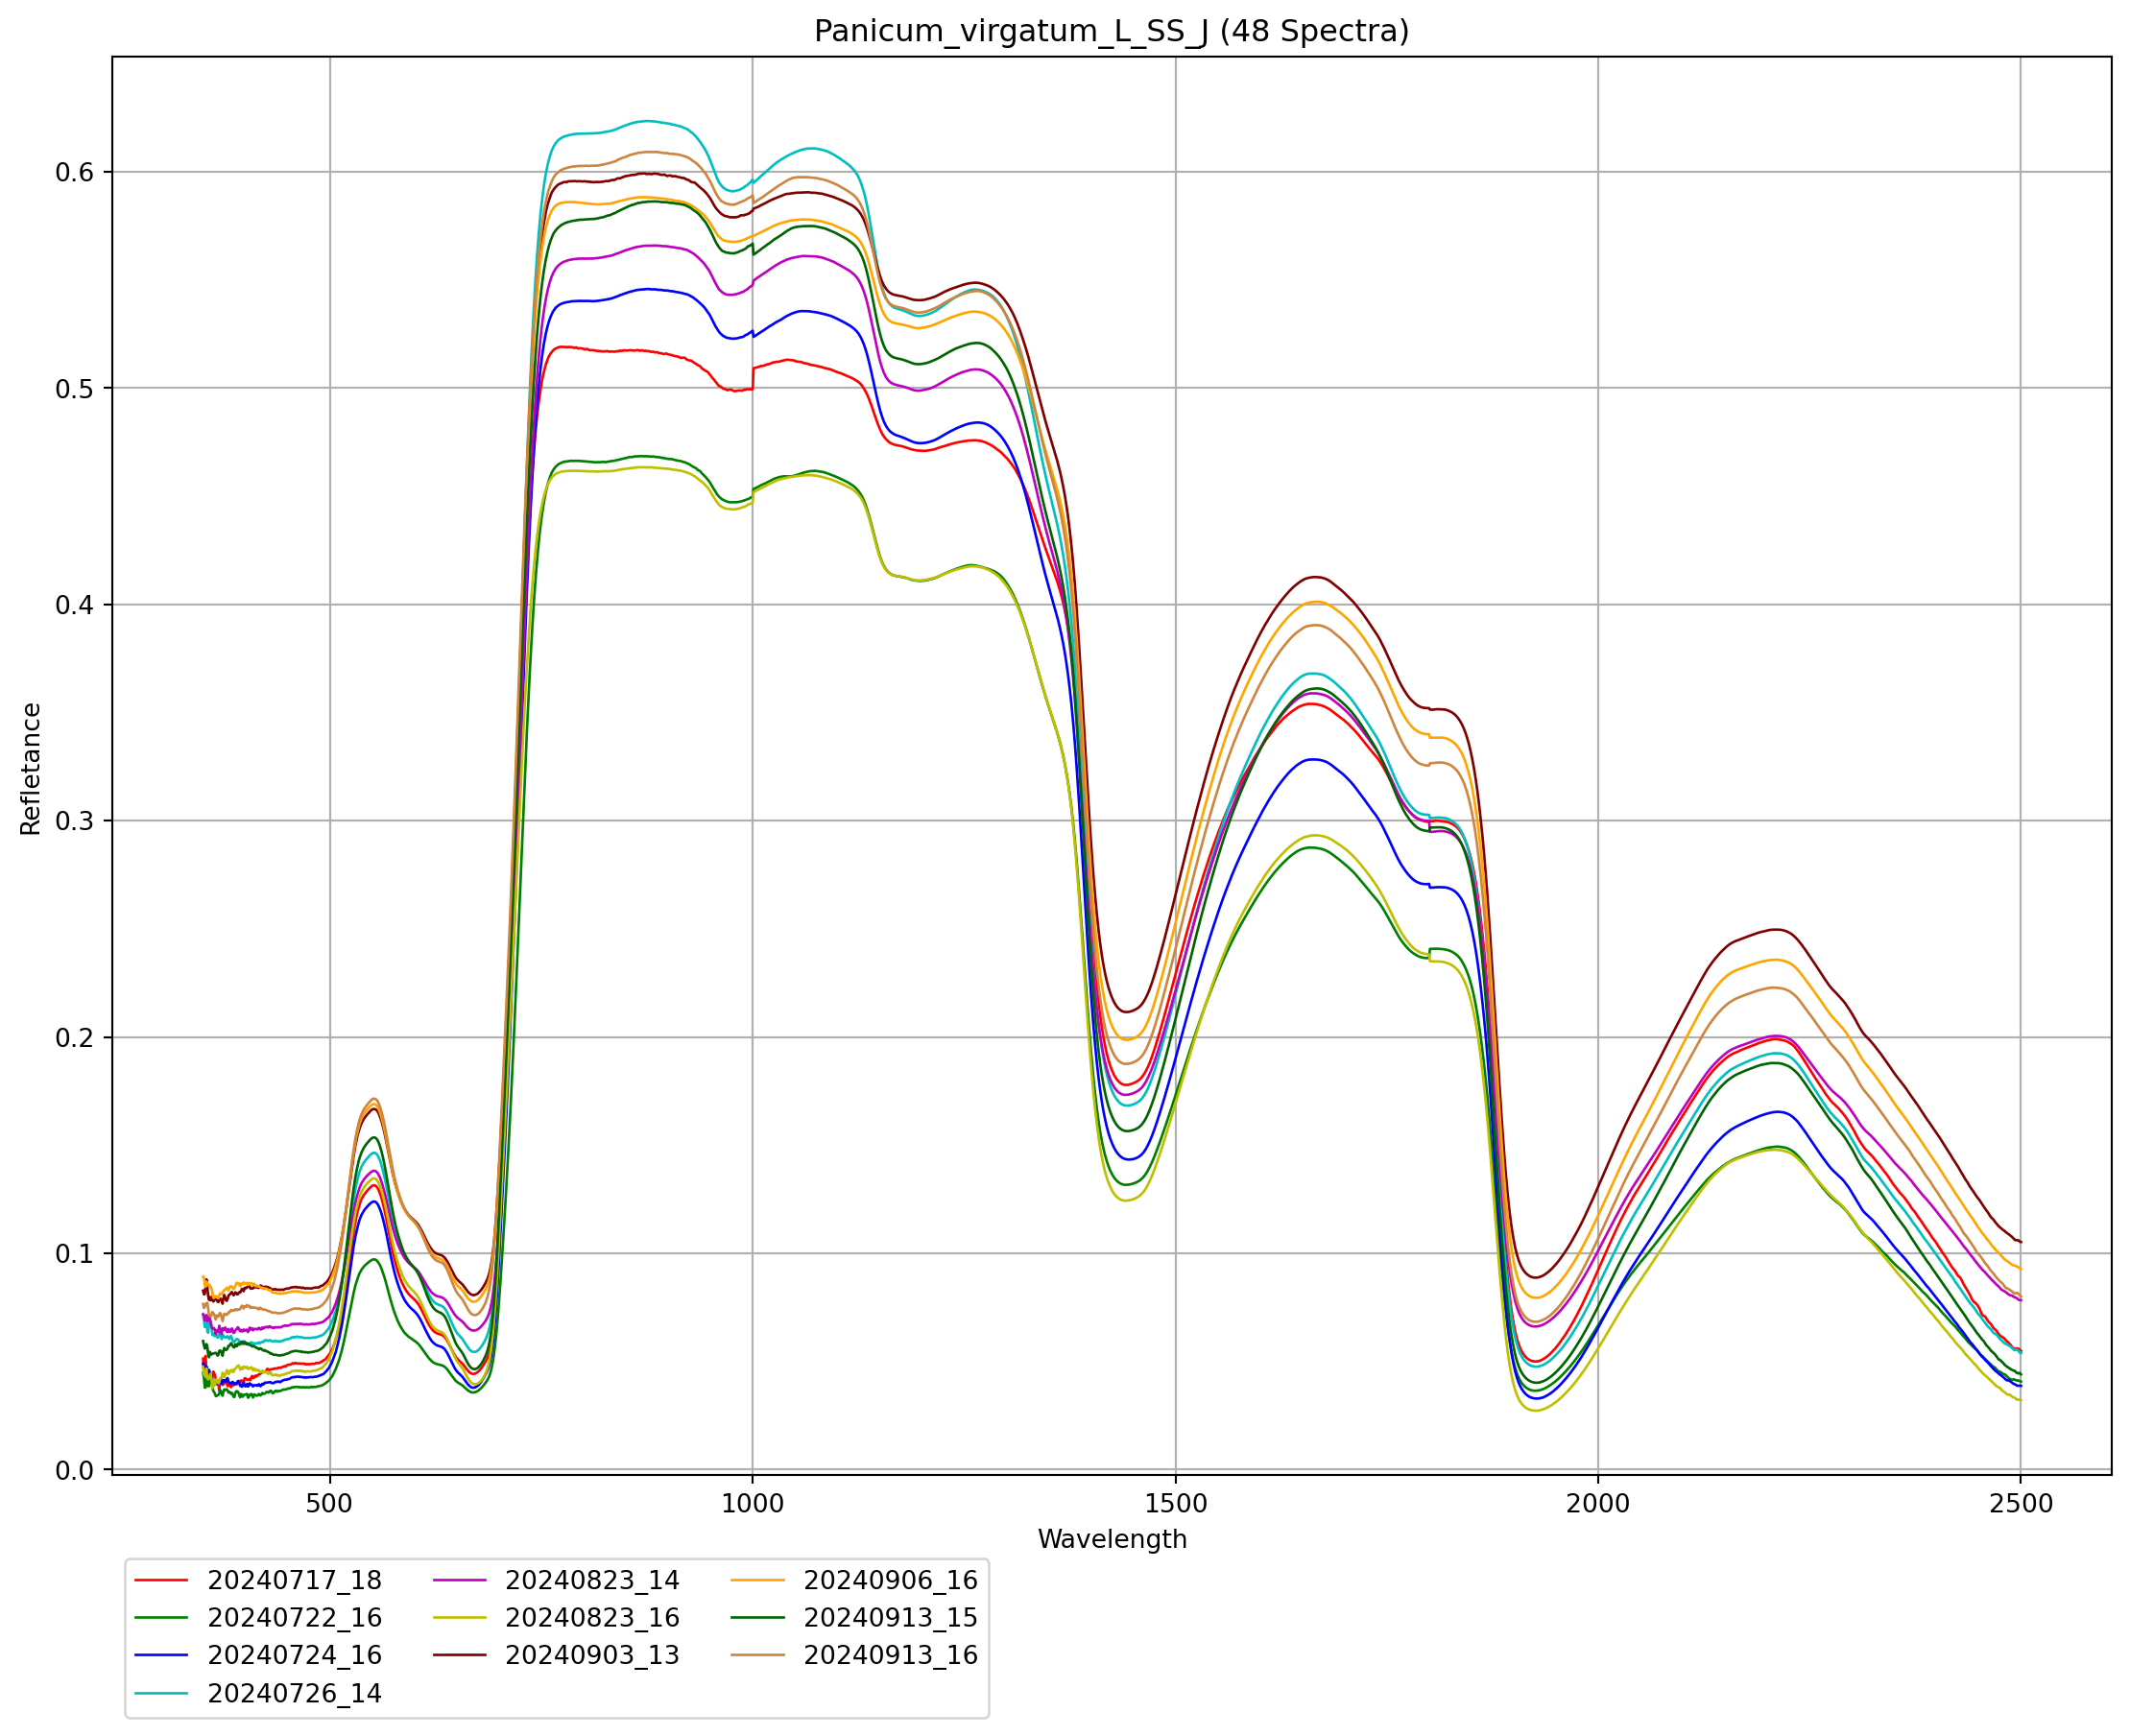

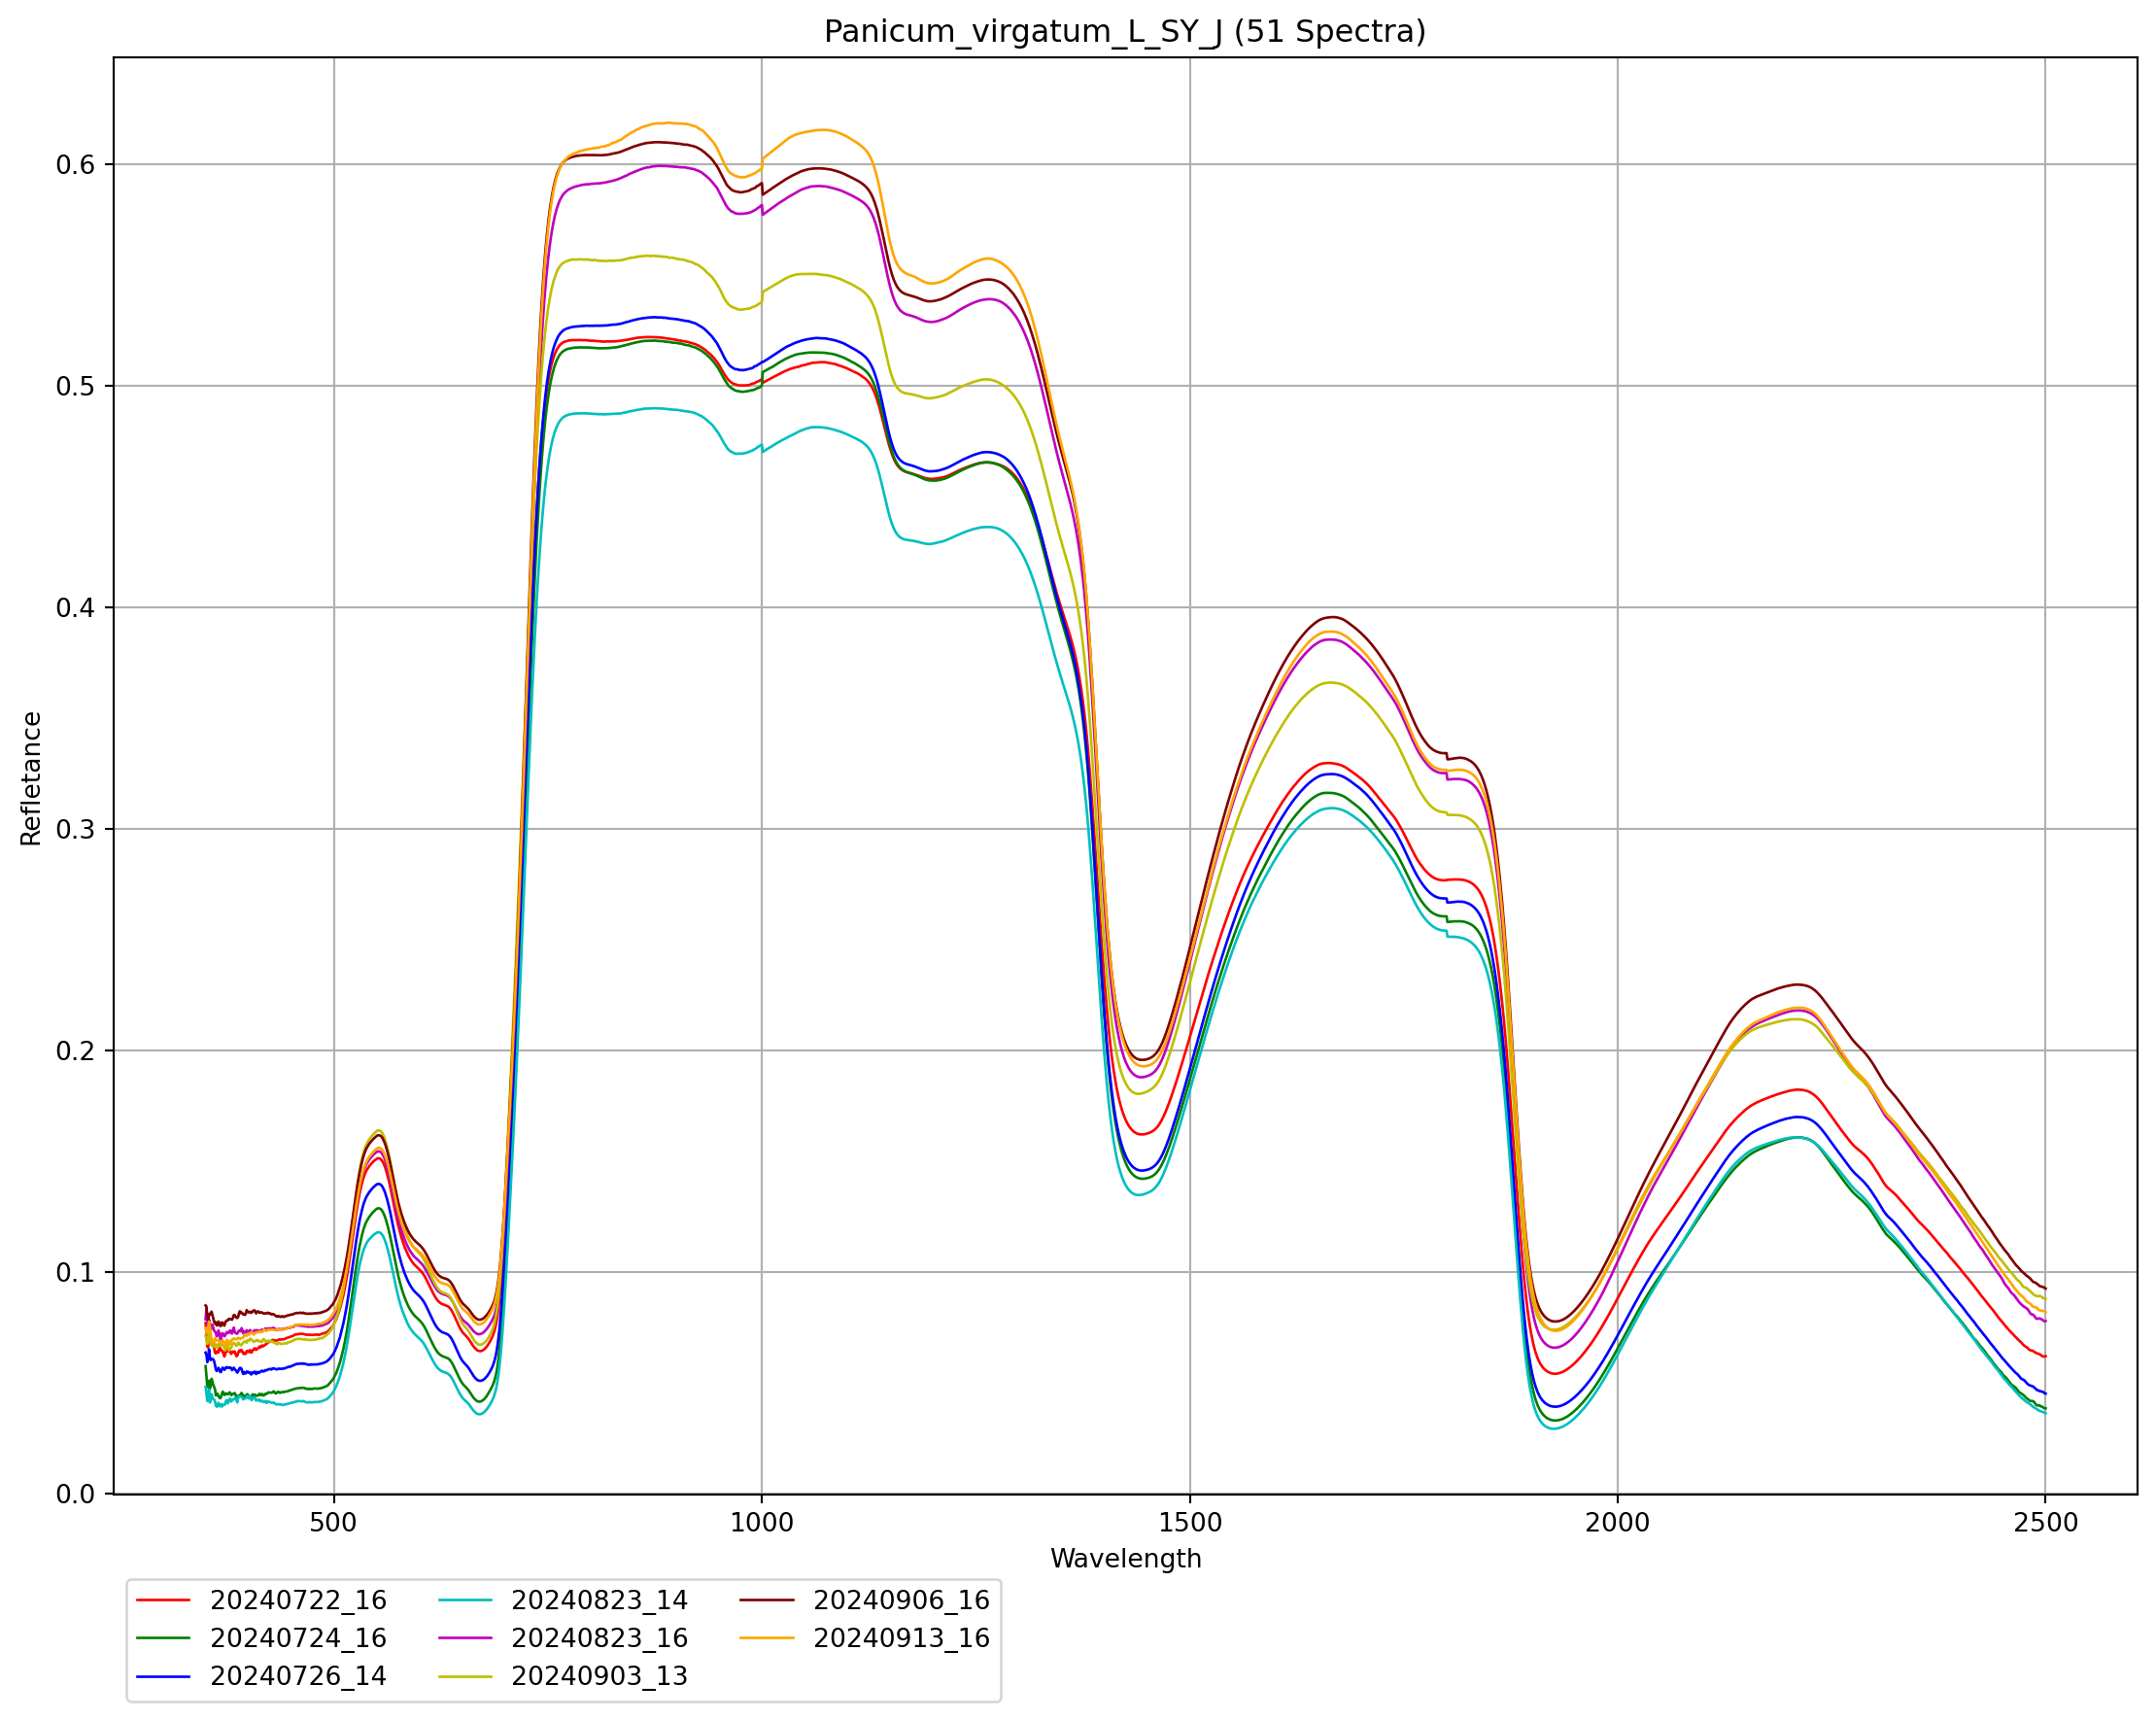

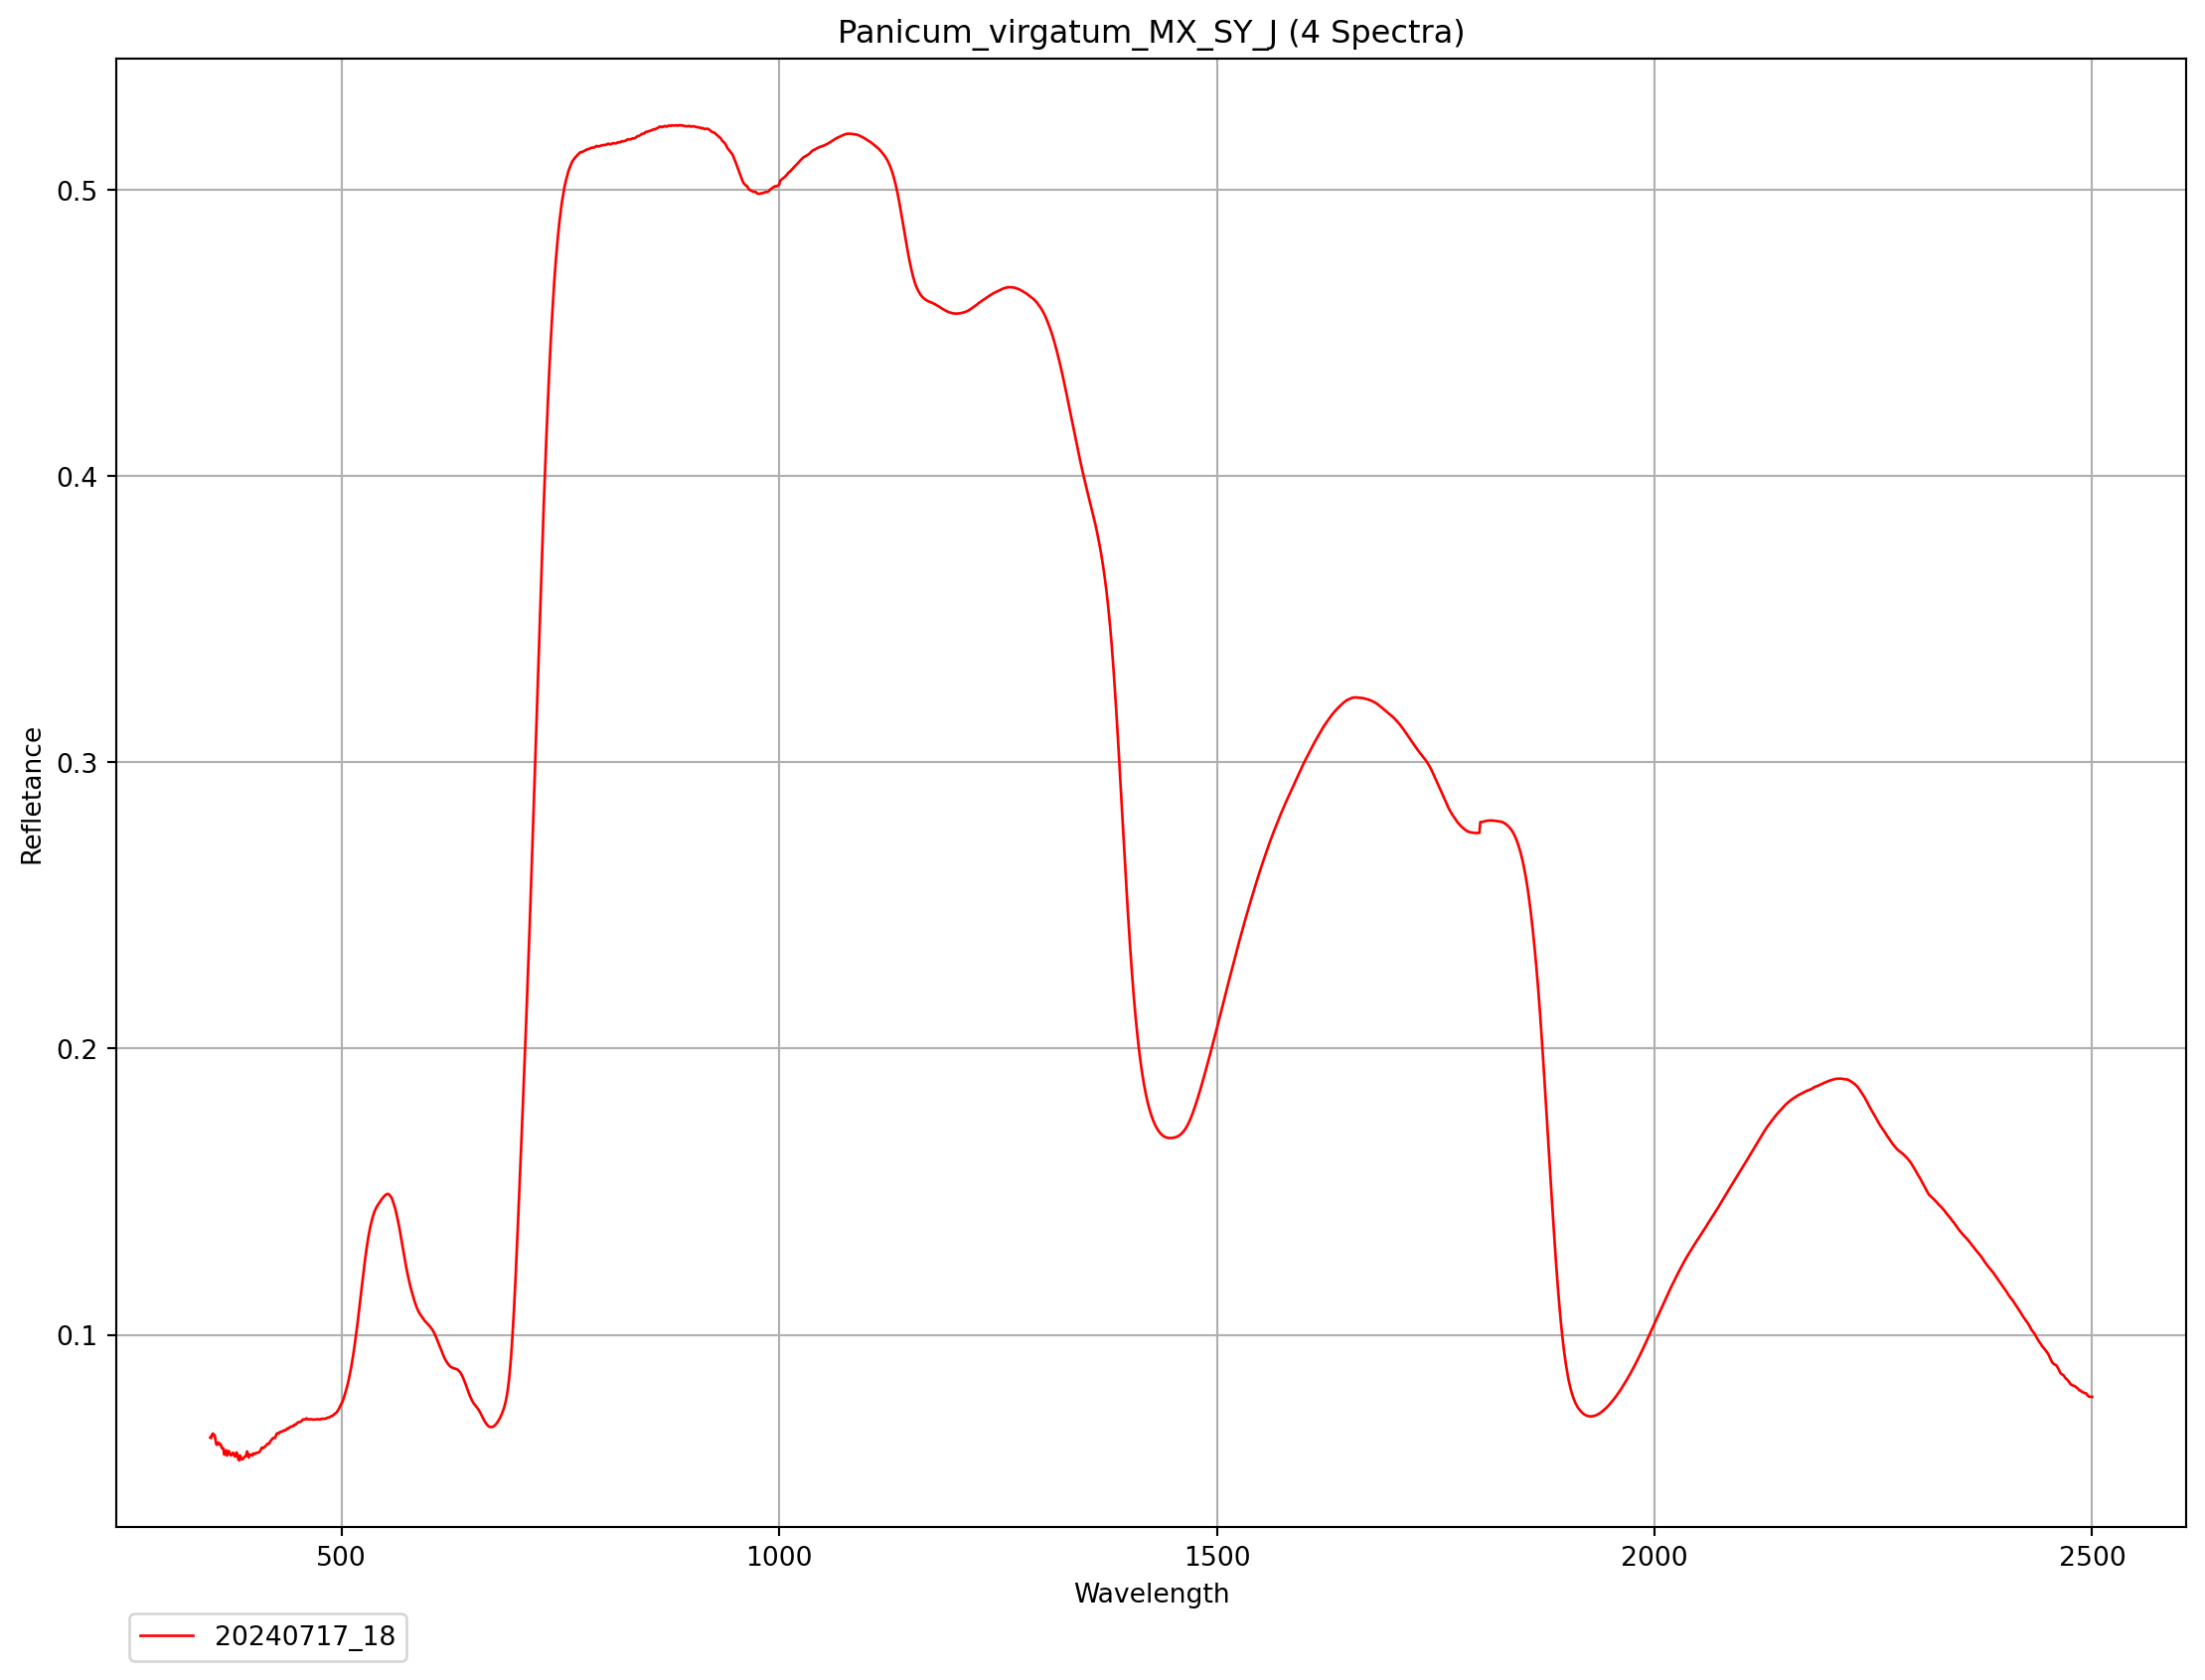

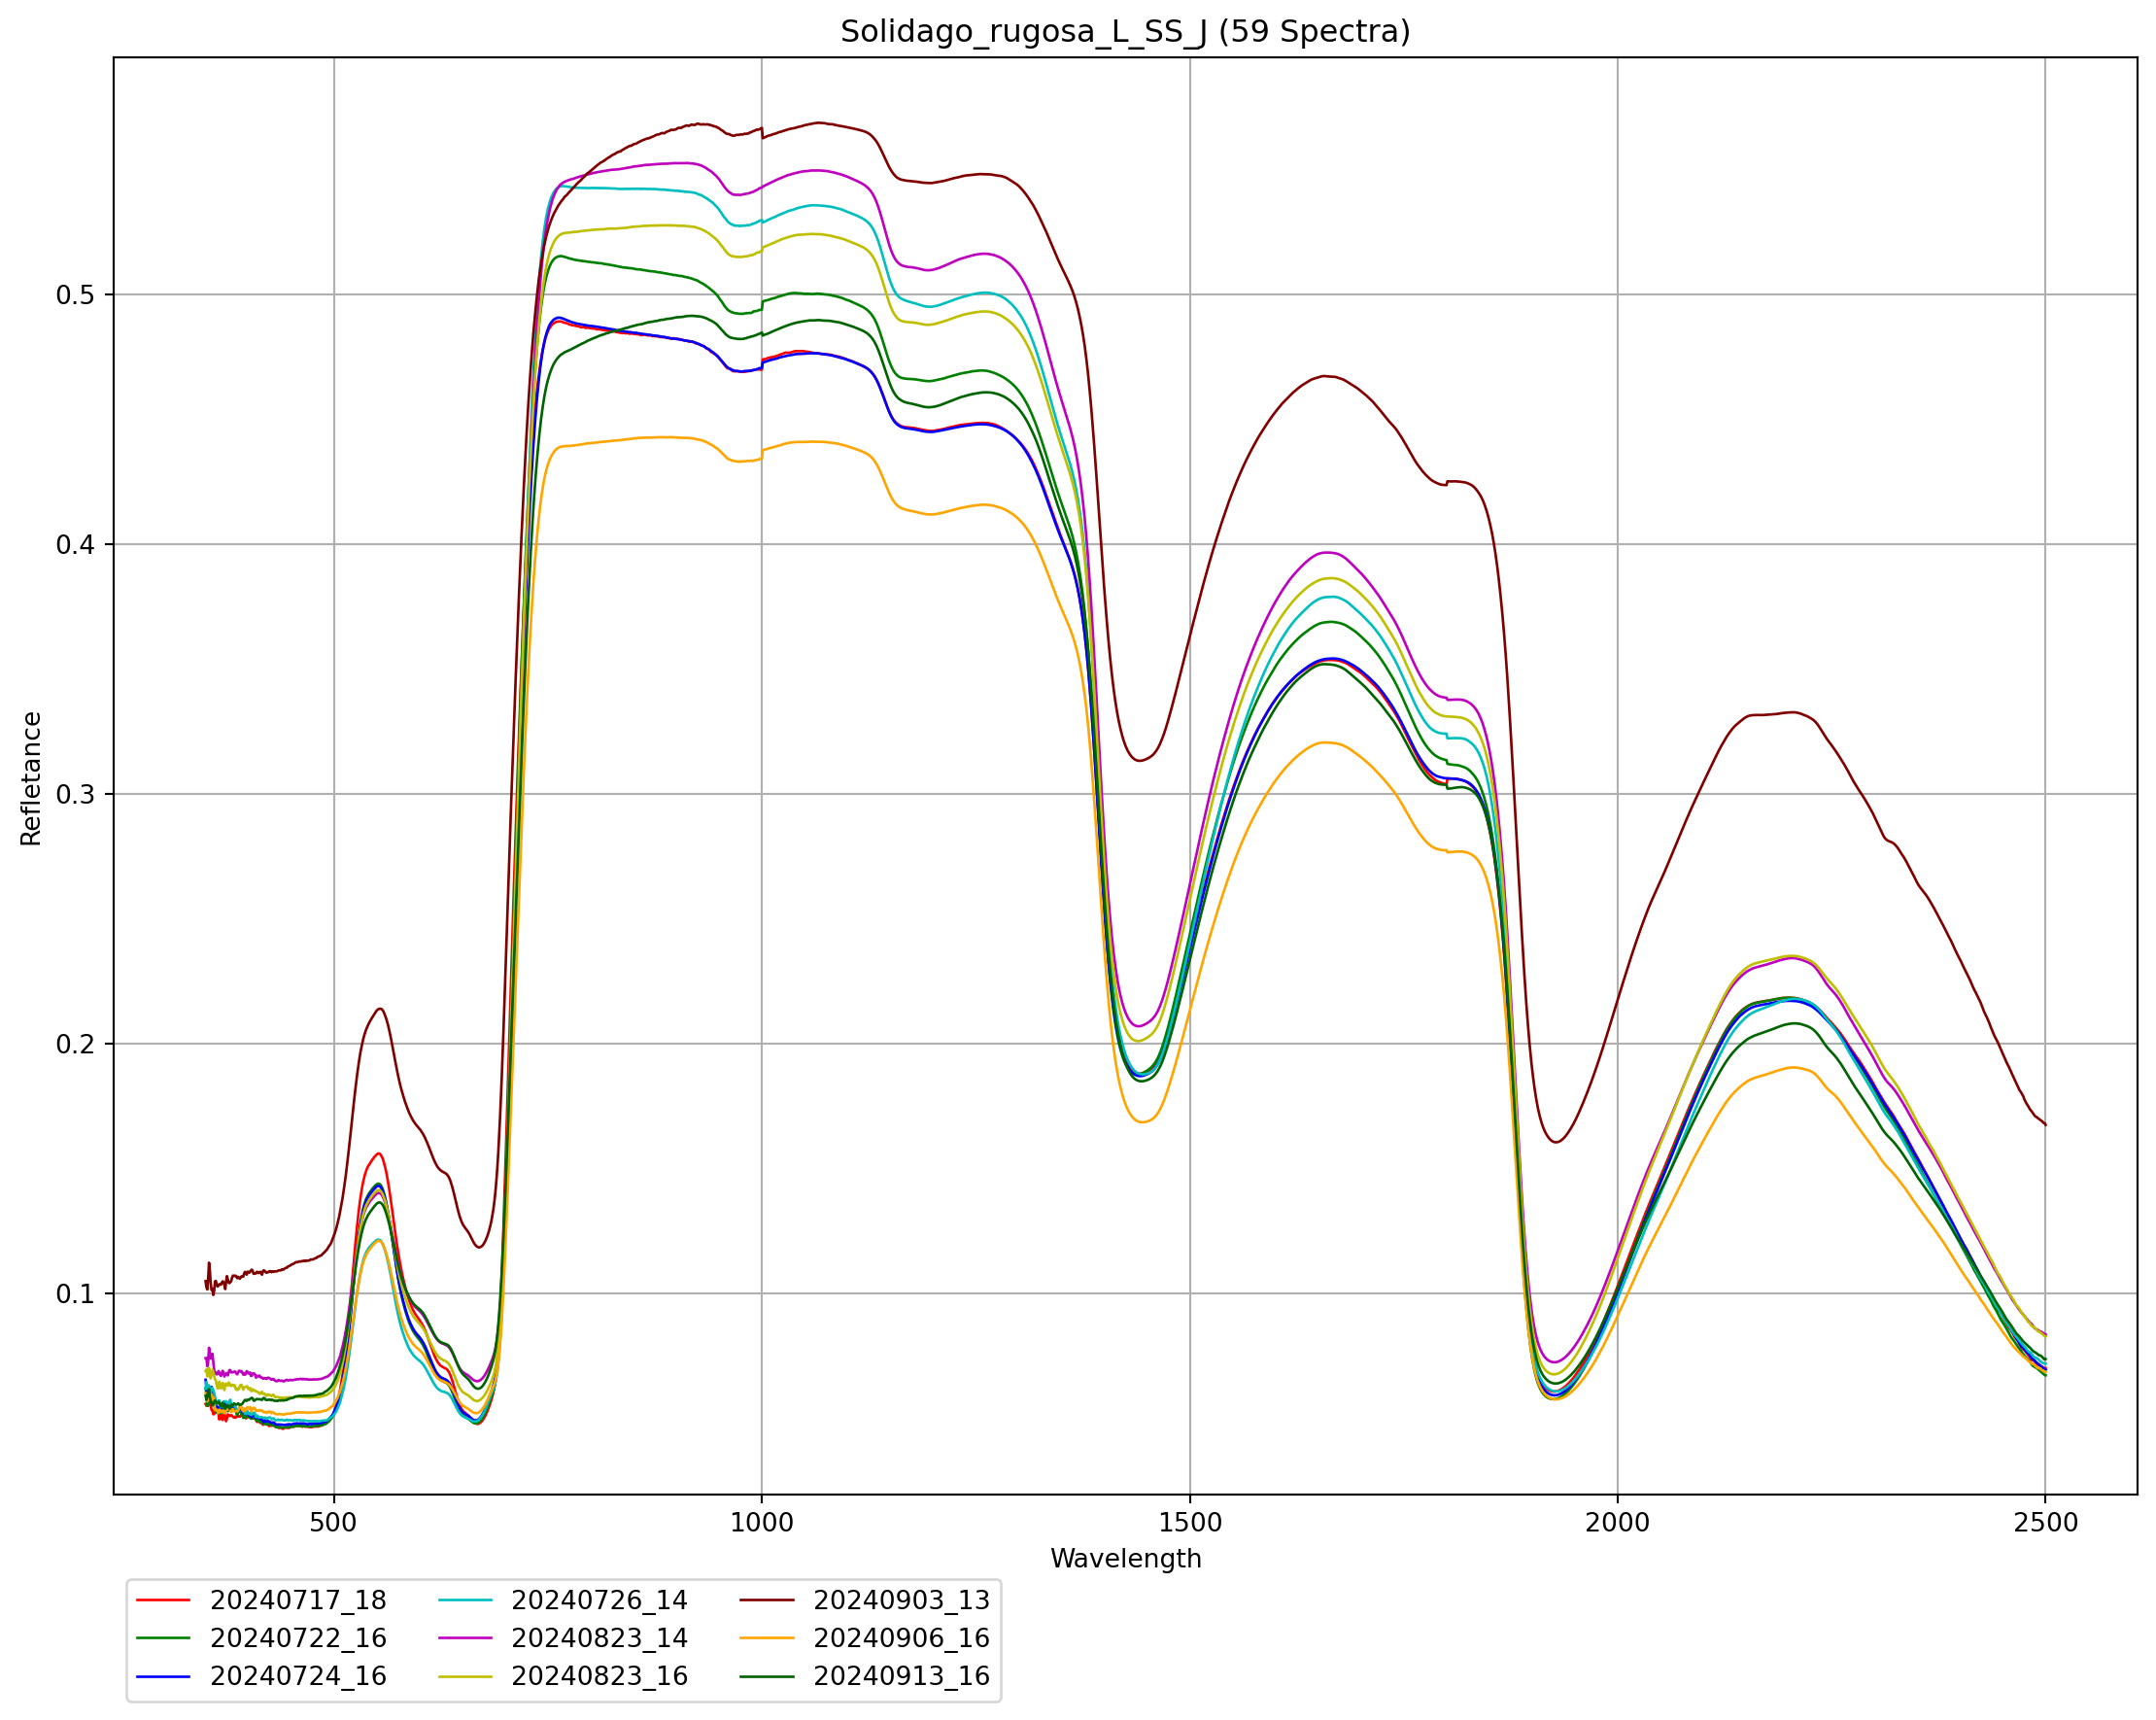

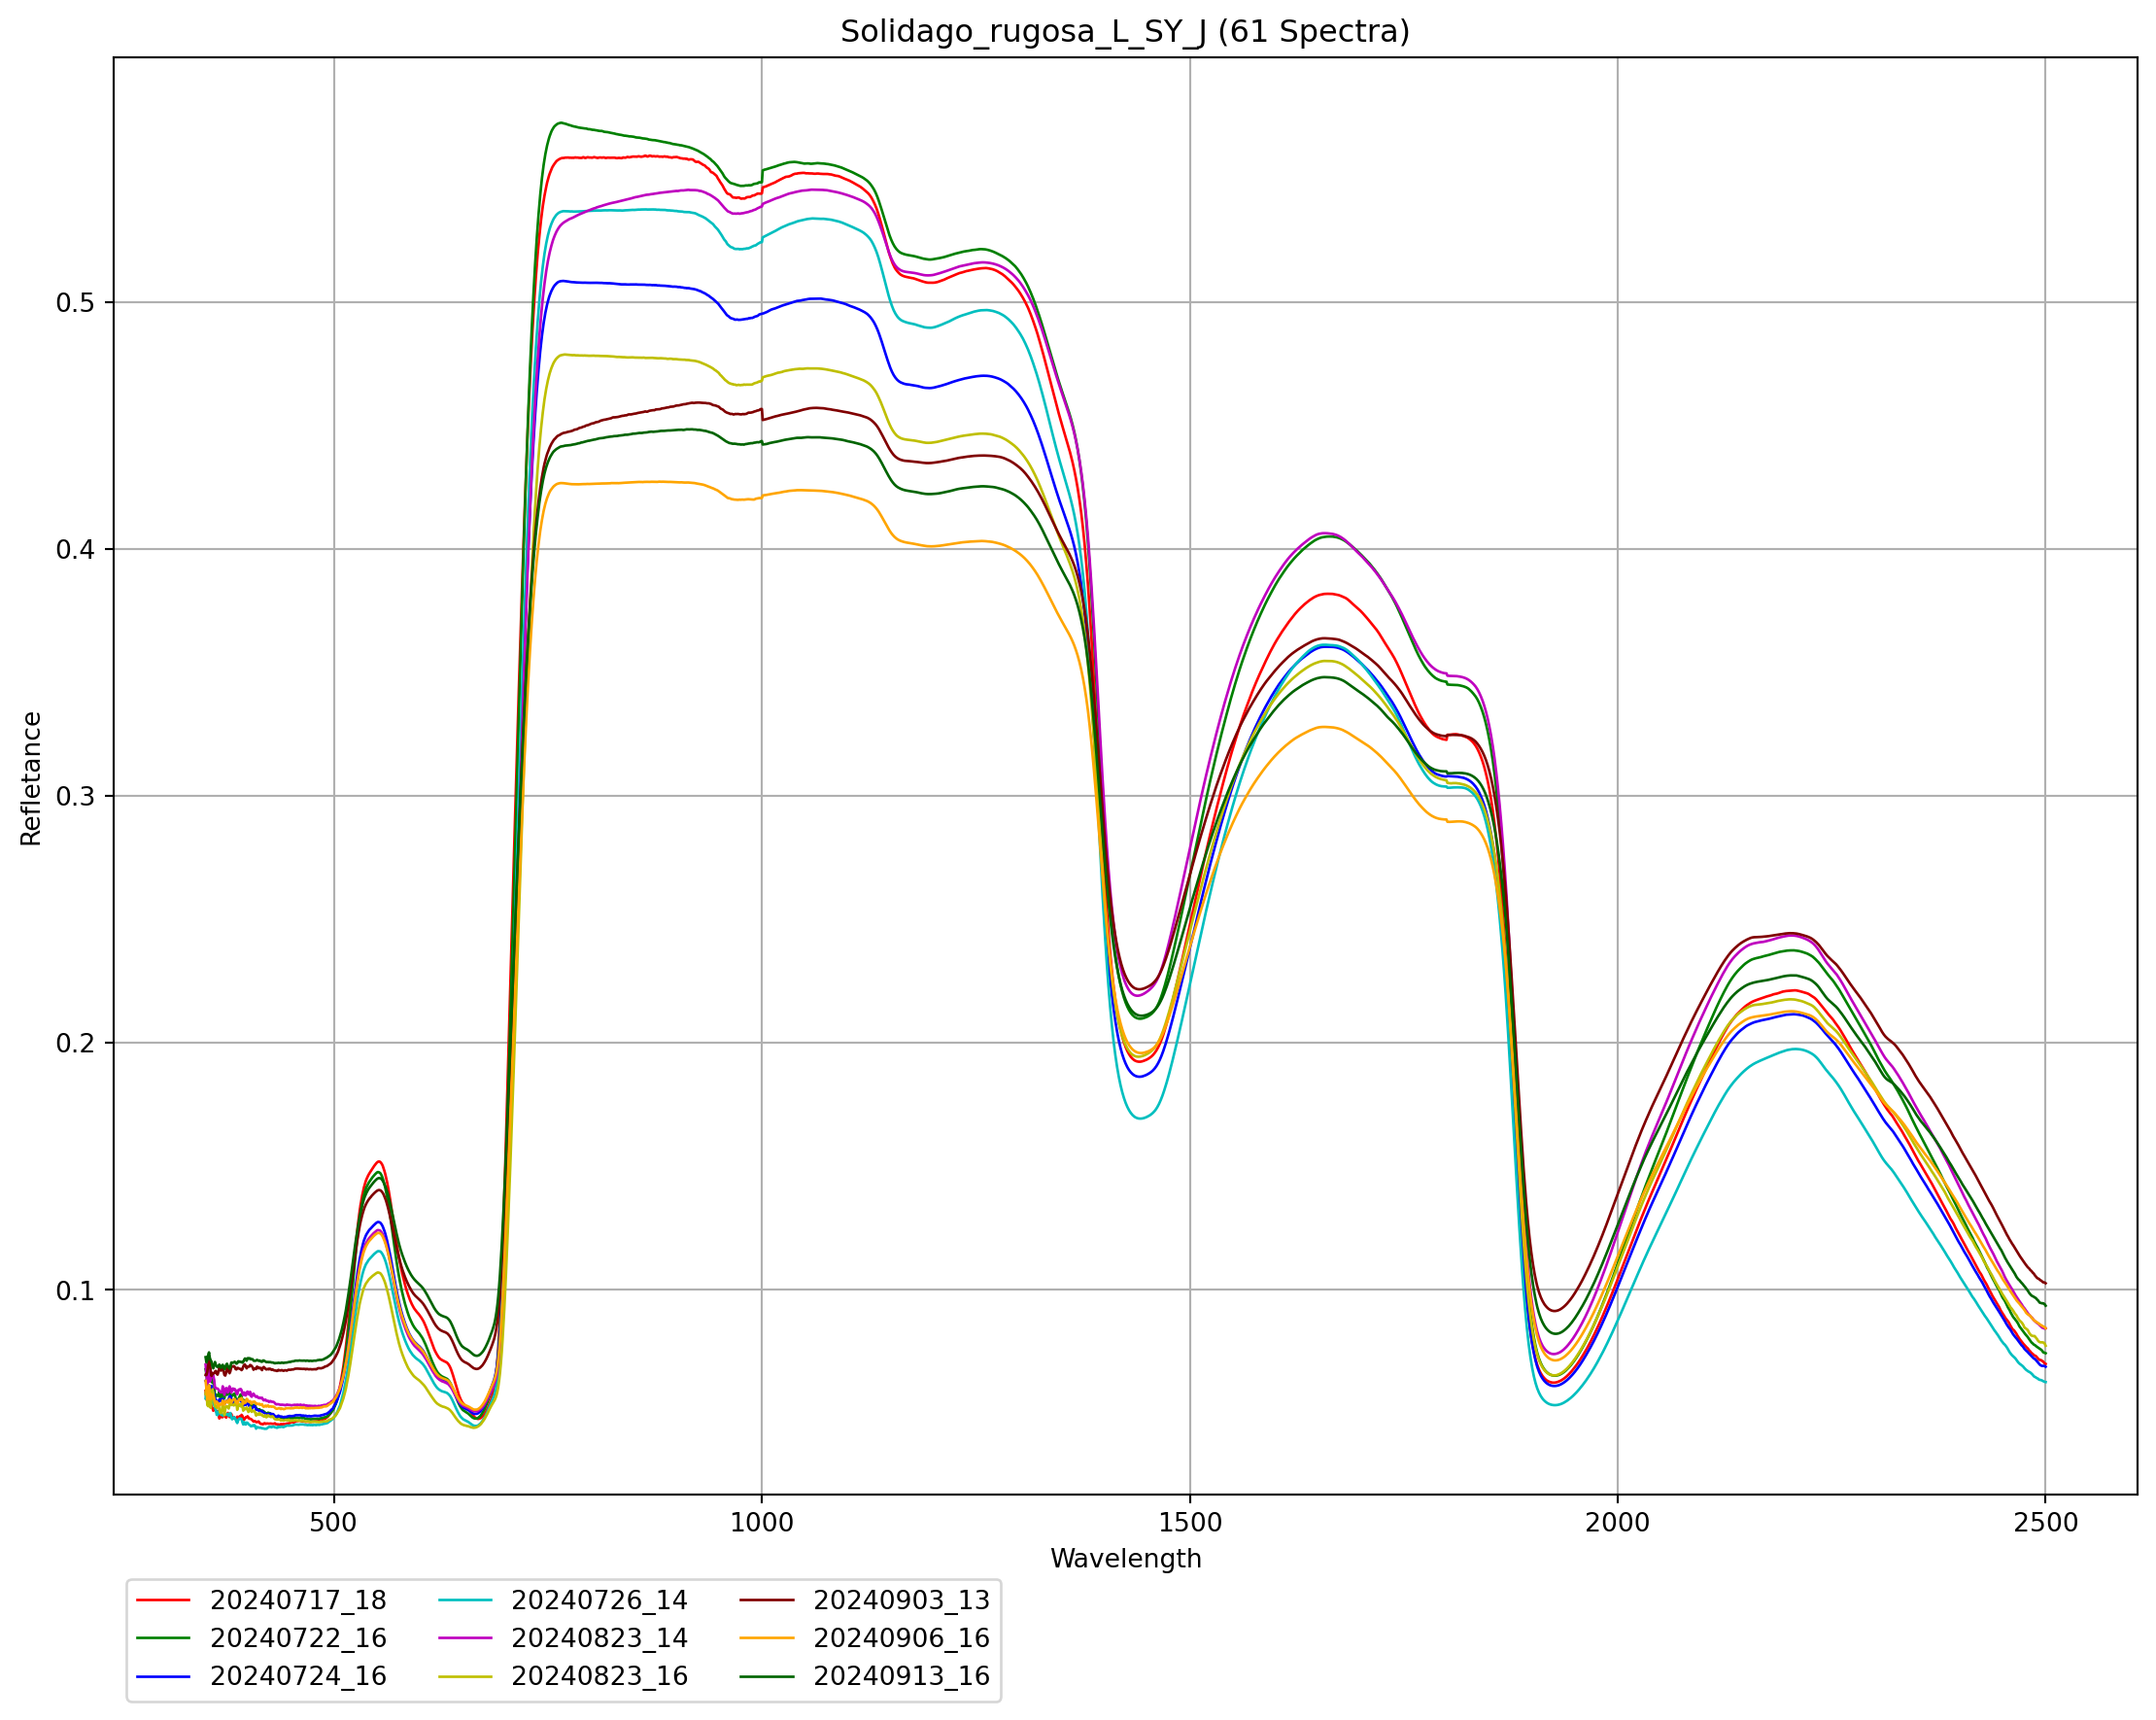

In [13]:
#| column: page-inset-right

health_codes = ['SS', 'SY']
salt_stress_indices = np.where(np.isin(health, health_codes))[0]
#print(len(salt_stress_indices))

#salt_stress_indices2 = health[(health == 'SS') | (health == 'SY')]
#print(len(salt_stress_indices2))

for n in np.unique(name_full_category[salt_stress_indices]):
    #print(n)
    plot_spectra_for_name_full_category_by_date(n)
